# project_notebook of interdesciplinary school of neurosience students - fMRI department -  2025-2026

# Dataset (subset of UCLA Consortium LA5c; OpenfMRI ds000030)

You’ll work with **two healthy control subjects**. For each subject you’ll receive:

* **Structural (anat)**: T1-weighted image in MNI space (e.g., `wcsub-1_T1w.nii`), suitable as a background for stats/visualization. Masks/atlases can be overlaid on this space. 
* **Functional (func) — Rest**: a preprocessed resting-state BOLD run (denoised and normalized in **CONN** beforehand). You’ll compute ROI-to-ROI and seed-to-voxel functional connectivity from the cleaned time series, applying **Fisher Z** transforms for statistics and (optionally) back-transforming to r for reporting. 
* **Functional (func) — Stop-Signal Task (SST)**: a preprocessed task BOLD run plus its `*_events.tsv` and the SPM motion file `rp_sub-*_task-stopsignal_bold.txt`. You’ll build a **first-level GLM**, define contrasts, and interpret z/t maps; motion and other nuisance terms are included as **confounds** (e.g., 24HMP built from the rp file). 

Your folder layout (example for sub-1) looks like:

```
\data.project\sub-1\
  anat\
    wcsub-1_T1w.nii
  func\
    rest\  ... (preprocessed rsfMRI + rp_sub-1_task-rest_bold.txt)
    stopsignal_task\
      swausub-1_task-stopsignal_bold.nii
      sub-1_task-stopsignal_events.tsv
      rp_sub-1_task-stopsignal_bold.txt
```

> **Why these files?**
>
> * **GLM** needs the preprocessed BOLD, an **events table** (onset/duration/trial_type), and a confounds matrix (from **rp** motion, WM/CSF, scrubbing if used). 
> * **Connectivity** needs denoised time series and ROI definitions (atlas labels or seeds); Fisher **arctanh** improves normality for averaging/testing. 
> * Masks/atlases (e.g., Harvard–Oxford/Schaefer) let you extract regional signals cleanly. 

# The Stop-Signal Task (SST): what students should know

* **Goal**: measure **response inhibition**—the ability to cancel a prepared response.
* **Trial structure**: most trials are **Go** (press quickly to a cue). On some trials, a later **auditory/visual “stop signal”** appears after a **stop-signal delay (SSD)**; participants must **withhold** the response.
* **Outcomes/conditions** (typical):

  * *Go correct* (successful go)
  * *Stop success* (successful inhibition)
  * *Stop failure* (couldn’t inhibit)
* **First-level GLM ideas**: model each condition (HRF-convolved) and test contrasts such as **Stop > Go**, **Stop-success > Stop-failure**, or **(Stop > Go) per subject**. Include motion + other confounds to avoid bias. 
* **Connectivity ideas**: derive **seed-to-voxel** or **ROI-to-ROI** connectivity from rest; for task-modulated connectivity, extensions like **beta-series** or **PPI** can be explored after the basic GLM. Apply **Fisher Z** to correlations before group stats. 

---




# Task 1  — “Sanity report”: check headers, timing, events, and confounds

**Goal.** For each subject, automatically:

* find the **anat**, **SST**, and **REST** files,
* read the **BOLD header** (TR, #volumes, scan duration),
* verify **events** (SST): all onsets/durations fit within the scan,
* verify **confounds**: rows in `rp_*.txt` match #volumes,

In [6]:
from pathlib import Path
import nibabel as nib
import numpy as np
import pandas as pd

# ---------- config ----------
BASE = Path(r"H:\ML.neuroimaging\teaching\S 11\data.project")
SUBS = ["sub-1", "sub-2"]  # adjust to your actual subject IDs
OUT_CSV = BASE / "project_sanity_report.csv"

# ---------- helpers ----------
def find_one(folder: Path, pattern: str):
    hits = sorted(folder.glob(pattern))
    return hits[0] if hits else None

def epi_meta(epi_path: Path):
    img = nib.load(str(epi_path))
    shape = img.shape
    tr = img.header.get_zooms()[-1] if len(shape) == 4 else np.nan
    nvol = shape[-1] if len(shape) == 4 else 1
    dur = tr * nvol if tr == tr else np.nan
    return tr, nvol, dur

def check_events(events_path: Path, scan_duration: float):
    if events_path is None or not events_path.exists():
        return np.nan, np.nan, "missing"
    ev = pd.read_csv(events_path, sep="\t")
    if not {"onset","duration"}.issubset(ev.columns):
        return len(ev), np.nan, "bad_cols"
    last_end = float((ev["onset"] + ev["duration"]).max())
    ok = last_end <= (scan_duration + 1e-3)  # small tolerance
    return len(ev), last_end, "ok" if ok else "exceeds_scan"

def check_rp(rp_path: Path, nvol: int):
    if rp_path is None or not rp_path.exists():
        return np.nan, "missing"
    try:
        rp = np.loadtxt(rp_path)
        rows = rp.shape[0]
        return rows, "ok" if rows == nvol else f"mismatch({rows}!={nvol})"
    except Exception as e:
        return np.nan, f"error:{e}"

# ---------- main ----------
rows = []
for sub in SUBS:
    sub_dir = BASE / sub

    # ANAT
    anat = find_one(sub_dir / "anat", "wc*_*T1w*.nii*")
    anat_ok = "ok" if anat and anat.exists() else "missing"

    # SST
    sst_dir = sub_dir / "func" / "stopsignal_task"
    sst_epi = find_one(sst_dir, "*stopsignal*bold*.nii*")
    sst_tr, sst_nvol, sst_dur = (np.nan, np.nan, np.nan) if not sst_epi else epi_meta(sst_epi)
    sst_events = (sst_dir / f"{sub}_task-stopsignal_events.tsv")
    if not sst_events.exists():
        # fall back to any events file in the folder
        sst_events = find_one(sst_dir, "*stopsignal*events*.tsv")
    sst_n_events, sst_last_end, sst_ev_status = check_events(sst_events, sst_dur if sst_dur==sst_dur else 0.0)
    sst_rp = sst_dir / f"rp_{sub}_task-stopsignal_bold.txt"
    sst_rp_rows, sst_rp_status = check_rp(sst_rp, int(sst_nvol) if sst_nvol==sst_nvol else -1)

    # REST
    rest_dir = sub_dir / "func" / "rest"
    rest_epi = find_one(rest_dir, "*rest*bold*.nii*") or find_one(rest_dir, "*rest*.nii*")
    rest_tr, rest_nvol, rest_dur = (np.nan, np.nan, np.nan) if not rest_epi else epi_meta(rest_epi)
    rest_rp = rest_dir / f"rp_{sub}_task-rest_bold.txt"
    rest_rp_rows, rest_rp_status = check_rp(rest_rp, int(rest_nvol) if rest_nvol==rest_nvol else -1)

    rows.append({
        "subject": sub,



        "sst_TR(s)": round(float(sst_tr), 3) if sst_tr==sst_tr else np.nan,
        "sst_nvol": int(sst_nvol) if sst_nvol==sst_nvol else np.nan,
        "sst_duration(s)": round(float(sst_dur), 2) if sst_dur==sst_dur else np.nan,


        "sst_n_events": int(sst_n_events) if sst_n_events==sst_n_events else np.nan,
        "sst_last_event_end(s)": round(float(sst_last_end), 2) if sst_last_end==sst_last_end else np.nan,
        "sst_events_status": sst_ev_status,

        "sst_rp_rows": int(sst_rp_rows) if sst_rp_rows==sst_rp_rows else np.nan,
        "sst_rp_status": sst_rp_status,


        "rest_TR(s)": round(float(rest_tr), 3) if rest_tr==rest_tr else np.nan,
        "rest_nvol": int(rest_nvol) if rest_nvol==rest_nvol else np.nan,
        "rest_duration(s)": round(float(rest_dur), 2) if rest_dur==rest_dur else np.nan,

        "rest_rp_rows": int(rest_rp_rows) if rest_rp_rows==rest_rp_rows else np.nan,
        "rest_rp_status": rest_rp_status,
    })

report = pd.DataFrame(rows)
report



,subject,sst_TR(s),sst_nvol,sst_duration(s),sst_n_events,sst_last_event_end(s),sst_events_status,sst_rp_rows,sst_rp_status,rest_TR(s),rest_nvol,rest_duration(s),rest_rp_rows,rest_rp_status
0,sub-1,2.0,184,368.0,256,352.38,ok,184,ok,2.0,152,304.0,152,ok
1,sub-2,2.0,184,368.0,256,353.51,ok,184,ok,2.0,152,304.0,152,ok




## 🧠 **Task 2 — Head Motion Analysis & Confound Preparation**

### 🎯 **Goal**

1. Load each subject’s **motion parameters** (`rp_*.txt`).
2. Compute **Framewise Displacement (FD)** — a single number per fMRI frame showing how much the head moved since the previous scan.
3. Visualize FD across time for **rest** and **task** runs, highlighting high-motion spikes.
4. Identify frames exceeding a **0.5 mm** threshold and create **scrubbing regressors** for them.
5. Assemble a full confound matrix: **24HMP + FD + scrubs**, and save it for future GLM / connectivity analysis.

---

### 🧩 **Concept — What is Framewise Displacement?**

* **FD** quantifies instantaneous head motion between consecutive fMRI volumes.
* Computed as the **sum of absolute changes** in translations (mm) and rotations (converted to mm by multiplying radians × 50 mm, an approximate head radius).


**Framewise Displacement (Power et al., 2012)**

$$
FD_t = |\Delta x_t| + |\Delta y_t| + |\Delta z_t| + 50(|\Delta \alpha_t| + |\Delta \beta_t| + |\Delta \gamma_t|)
$$


where (x,y,z) are translations (mm) and (\alpha,\beta,\gamma) are rotations (radians).

* High FD (> 0.5 mm) = sudden head movement → artifacts in BOLD signal.
  Such frames should be modeled out (**scrubbed**) in later analyses.

---

### 🧾 **Expected Outcome**

*  **plot FD traces** for each subject/run and visually spot spikes.
* They will see how many frames exceed 0.5 mm and understand motion-induced noise.
* The final **confound matrix** includes:

  * 24 motion regressors (6 motion + derivatives + squares)
  * FD column
  * One dummy column per scrubbed frame





sub-1 sst: TR = 2.00s | Volumes = 184


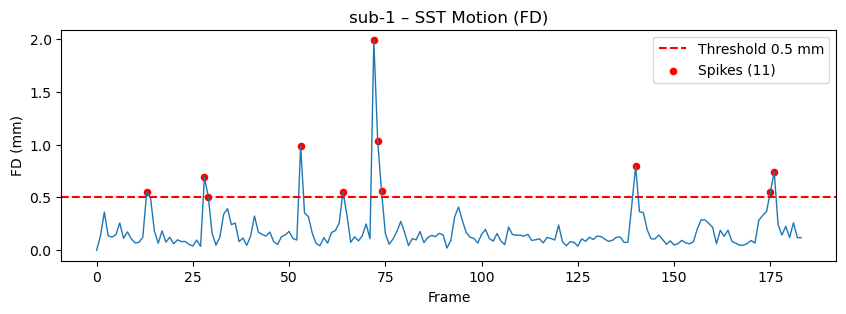

 Frames >0.5 mm: 11
 Confounds shape: (184, 36)


,Tx,Ty,Tz,Rx,Ry,Rz,dTx,dTy,dTz,dRx,...,scrub_028,scrub_029,scrub_053,scrub_064,scrub_072,scrub_073,scrub_074,scrub_140,scrub_175,scrub_176
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.012853,0.006520,0.030722,0.000027,0.001007,-0.000688,-0.012853,0.006520,0.030722,0.000027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.059974,-0.013515,0.179766,0.000929,0.000455,0.000241,0.072827,-0.020034,0.149045,0.000902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.077113,-0.032324,0.197908,0.000172,-0.000065,-0.000127,0.017139,-0.018809,0.018142,-0.000757,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.083853,-0.074114,0.181069,-0.000195,0.000234,0.000390,0.006741,-0.041790,-0.016839,-0.000367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.099596,-0.089203,0.255531,-0.000877,0.000121,0.000428,0.015742,-0.015090,0.074462,-0.000682,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.156140,-0.103429,0.323096,-0.002680,0.000071,0.000963,0.056544,-0.014226,0.067565,-0.001803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.159740,-0.148816,0.297770,-0.002257,0.000319,0.000868,0.003600,-0.045387,-0.025326,0.000423,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.192138,-0.158862,0.382366,-0.002641,0.000271,0.001368,0.032397,-0.010046,0.084596,-0.000383,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.179130,-0.149330,0.348929,-0.002803,-0.000112,0.000863,-0.013008,0.009532,-0.033437,-0.000162,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 Saved confounds → sub-1_sst_confounds.tsv

sub-1 rest: TR = 2.00s | Volumes = 152


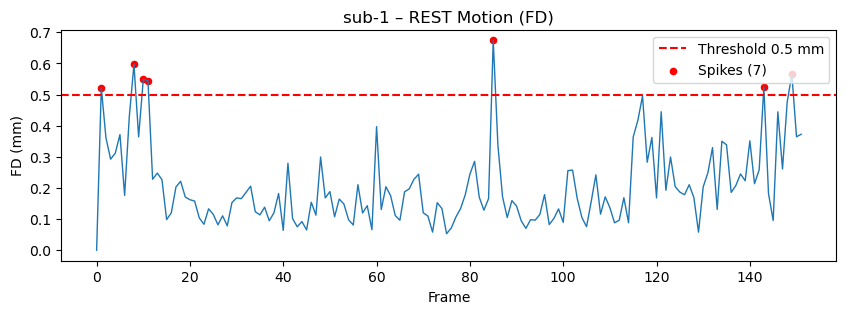

 Frames >0.5 mm: 7
 Confounds shape: (152, 32)


,Tx,Ty,Tz,Rx,Ry,Rz,dTx,dTy,dTz,dRx,...,dRy2,dRz2,FD,scrub_001,scrub_008,scrub_010,scrub_011,scrub_085,scrub_143,scrub_149
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.017506,0.019334,0.264937,-0.002314,-0.001018,-0.001072,-0.017506,0.019334,0.264937,-0.002314,...,1.037148e-06,1.148170e-06,0.521966,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.041411,-0.072509,0.185377,-0.001131,-0.000090,-0.000575,0.058917,-0.091842,-0.079561,0.001183,...,8.625844e-07,2.470092e-07,0.360742,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.048669,-0.005870,0.298850,-0.002151,-0.000803,-0.000944,0.007258,0.066639,0.113473,-0.001019,...,5.090735e-07,1.367034e-07,0.292503,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.008841,-0.037962,0.430347,-0.003139,-0.001244,-0.001686,-0.039828,-0.032093,0.131497,-0.000988,...,1.947588e-07,5.506477e-07,0.312006,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.007497,-0.100026,0.230737,-0.001266,-0.001012,-0.001751,-0.001344,-0.062064,-0.199610,0.001873,...,5.396013e-08,4.185689e-09,0.371517,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000381,0.001905,0.193238,-0.001109,-0.001081,-0.002115,-0.007116,0.101931,-0.037499,0.000157,...,4.724500e-09,1.328220e-07,0.176073,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.005521,0.007947,0.496117,-0.002446,-0.002016,-0.002127,-0.005902,0.006042,0.302879,-0.001338,...,8.744763e-07,1.359439e-10,0.429051,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.053781,-0.088826,0.858385,-0.002891,-0.002904,-0.001886,0.059302,-0.096773,0.362268,-0.000444,...,7.876115e-07,5.827270e-08,0.596998,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,0.078675,-0.196302,0.761671,-0.000747,-0.003160,-0.001585,0.024894,-0.107476,-0.096715,0.002143,...,6.574496e-08,9.020448e-08,0.364096,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 Saved confounds → sub-1_rest_confounds.tsv

sub-2 sst: TR = 2.00s | Volumes = 184


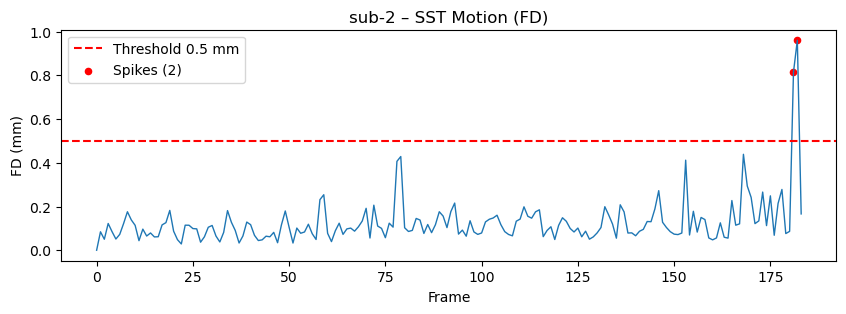

 Frames >0.5 mm: 2
 Confounds shape: (184, 27)


,Tx,Ty,Tz,Rx,Ry,Rz,dTx,dTy,dTz,dRx,...,Rz2,dTx2,dTy2,dTz2,dRx2,dRy2,dRz2,FD,scrub_181,scrub_182
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.0
1,-0.005295,-0.037702,-0.008354,0.000580,0.000021,0.000059,-0.005295,-0.037702,-0.008354,0.000580,...,3.435772e-09,0.000028,0.001421,0.000070,3.367577e-07,4.428757e-10,3.435772e-09,0.084350,0.0,0.0
2,-0.007250,-0.057099,-0.010045,0.000487,-0.000148,0.000340,-0.001954,-0.019397,-0.001691,-0.000094,...,1.155939e-07,0.000004,0.000376,0.000003,8.774172e-09,2.848965e-08,7.917221e-08,0.050233,0.0,0.0
3,0.000907,0.003160,0.019885,0.000329,-0.000199,0.000069,0.008157,0.060259,0.029930,-0.000157,...,4.820991e-09,0.000067,0.003631,0.000896,2.470466e-08,2.633543e-09,7.320145e-08,0.122298,0.0,0.0
4,-0.006127,-0.029765,-0.001987,0.000620,-0.000094,0.000139,-0.007034,-0.032926,-0.021872,0.000290,...,1.927610e-08,0.000049,0.001084,0.000478,8.436604e-08,1.107671e-08,4.817061e-09,0.085087,0.0,0.0
5,-0.004316,-0.016967,-0.032895,0.000708,-0.000091,0.000115,0.001811,0.012799,-0.030908,0.000088,...,1.328602e-08,0.000003,0.000164,0.000955,7.710638e-09,9.840863e-12,5.557047e-10,0.051243,0.0,0.0
6,-0.008032,-0.003369,0.001641,0.000645,-0.000188,-0.000137,-0.003716,0.013598,0.034536,-0.000063,...,1.874924e-08,0.000014,0.000185,0.001193,3.961544e-09,9.439034e-09,6.360126e-08,0.072464,0.0,0.0
7,-0.015470,-0.034938,-0.048927,0.001126,-0.000168,0.000010,-0.007439,-0.031569,-0.050568,0.000481,...,9.864313e-11,0.000055,0.000997,0.002557,2.314028e-07,3.755639e-10,2.156780e-08,0.121939,0.0,0.0
8,-0.023925,0.030898,0.007155,0.000701,-0.000050,-0.000360,-0.008455,0.065836,0.056082,-0.000424,...,1.296762e-07,0.000071,0.004334,0.003145,1.801103e-07,1.401640e-08,1.369279e-07,0.176015,0.0,0.0
9,-0.029405,-0.034982,-0.032467,0.001068,-0.000033,-0.000187,-0.005480,-0.065881,-0.039622,0.000367,...,3.487423e-08,0.000030,0.004340,0.001570,1.344813e-07,2.920423e-10,3.005347e-08,0.138841,0.0,0.0


 Saved confounds → sub-2_sst_confounds.tsv

sub-2 rest: TR = 2.00s | Volumes = 152


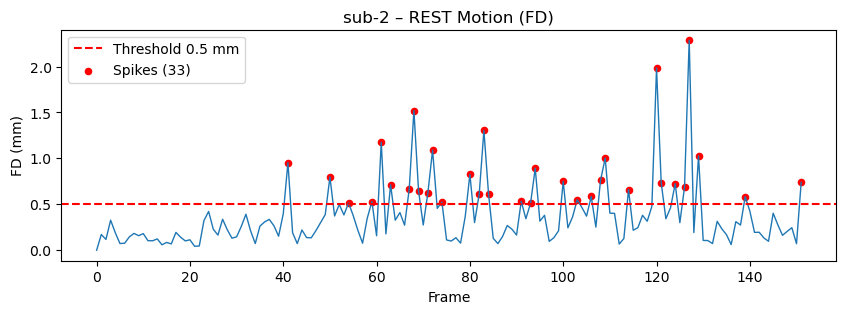

 Frames >0.5 mm: 33
 Confounds shape: (152, 58)


,Tx,Ty,Tz,Rx,Ry,Rz,dTx,dTy,dTz,dRx,...,scrub_109,scrub_114,scrub_120,scrub_121,scrub_124,scrub_126,scrub_127,scrub_129,scrub_139,scrub_151
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000475,-0.035399,-0.073256,0.000534,0.000572,0.000130,0.000475,-0.035399,-0.073256,0.000534,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.003919,0.011718,-0.022569,0.000285,0.000549,0.000091,-0.004394,0.047117,0.050687,-0.000249,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.022187,-0.037926,-0.205493,0.001357,0.000654,-0.000264,-0.018268,-0.049643,-0.182924,0.001072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.007777,-0.043134,-0.343649,0.001225,0.000857,0.000047,0.014410,-0.005208,-0.138156,-0.000132,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-0.000316,-0.023561,-0.314440,0.001081,0.000729,0.000110,0.007461,0.019573,0.029209,-0.000143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.006976,-0.053045,-0.340109,0.001097,0.000959,0.000080,0.007292,-0.029484,-0.025669,0.000016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.024162,0.004446,-0.305905,0.000699,0.001256,0.000065,0.017185,0.057491,0.034204,-0.000398,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.009357,-0.044104,-0.392424,0.001190,0.001424,0.000058,-0.014805,-0.048550,-0.086519,0.000491,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.006674,0.020190,-0.331482,0.000980,0.001381,-0.000297,-0.002682,0.064293,0.060943,-0.000210,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 Saved confounds → sub-2_rest_confounds.tsv


In [12]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib

# ---------- Configuration ----------
BASE = Path(r"H:\ML.neuroimaging\teaching\S 11\data.project")
SUBS = ["sub-1", "sub-2"]
FD_THRESH = 0.5          # mm threshold for scrubbing
ROT_RADIUS_MM = 50       # head radius for rotation conversion

# ---------- Helper Functions ----------
def build_24HMP(rp):
    """Compute 24 motion regressors: 6 + derivatives + squares + derivative-squares."""
    rp = np.asarray(rp)
    drp = np.vstack([np.zeros((1,6)), np.diff(rp, axis=0)])
    X = np.hstack([rp, drp, rp**2, drp**2])
    cols6 = ["Tx","Ty","Tz","Rx","Ry","Rz"]
    cols = cols6 + [f"d{k}" for k in cols6] + [f"{k}2" for k in cols6] + [f"d{k}2" for k in cols6]
    return pd.DataFrame(X, columns=cols)

def power_fd(rp):
    """Compute Framewise Displacement (Power et al., 2012)."""
    drp = np.vstack([np.zeros((1,6)), np.diff(rp, axis=0)])
    drp_mm = drp.copy()
    drp_mm[:,3:6] = np.abs(drp_mm[:,3:6]) * ROT_RADIUS_MM  # radians → mm
    return np.sum(np.abs(drp_mm), axis=1)

def make_scrub_matrix(n_vols, bad_idxs):
    """Create one-hot scrub regressors for high-motion frames."""
    X = np.zeros((n_vols, len(bad_idxs)))
    for j, t in enumerate(bad_idxs):
        if 0 <= t < n_vols:
            X[t, j] = 1.0
    return pd.DataFrame(X, columns=[f"scrub_{i:03d}" for i in bad_idxs])

def plot_fd(fd, thr, subj, run):
    """Interactive FD plot."""
    plt.figure(figsize=(10,3))
    plt.plot(fd, lw=1)
    plt.axhline(thr, color='r', ls='--', label=f'Threshold {thr} mm')
    bad = np.where(fd > thr)[0]
    plt.scatter(bad, fd[bad], color='r', s=20, label=f'Spikes ({len(bad)})')
    plt.xlabel("Frame")
    plt.ylabel("FD (mm)")
    plt.title(f"{subj} – {run.upper()} Motion (FD)")
    plt.legend()
    plt.show()

# ---------- Main Routine ----------
for sub in SUBS:
    for run_name, rp_file, epi_pattern in [
        ("sst", f"rp_{sub}_task-stopsignal_bold.txt", "*stopsignal*bold*.nii*"),
        ("rest", f"rp_{sub}_task-rest_bold.txt", "*rest*.nii*"),
    ]:
        run_dir = BASE / sub / "func" / ("stopsignal_task" if run_name == "sst" else "rest")

        epi_files = list(run_dir.glob(epi_pattern))
        if not epi_files:
            print(f"[{sub} {run_name}] No EPI found matching: {epi_pattern}")
            continue

        epi_img = nib.load(str(epi_files[0]))
        tr = epi_img.header.get_zooms()[-1]
        nvol = epi_img.shape[-1]
        print(f"\n{sub} {run_name}: TR = {tr:.2f}s | Volumes = {nvol}")

        rp_path = run_dir / rp_file
        if not rp_path.exists():
            print(f" Motion file missing: {rp_file}")
            continue

        # --- Compute motion metrics ---
        rp = np.loadtxt(rp_path)
        fd = power_fd(rp)
        bad_frames = np.where(fd > FD_THRESH)[0]

        # --- Visualize FD trace ---
        plot_fd(fd, FD_THRESH, sub, run_name)
        print(f" Frames >{FD_THRESH} mm: {len(bad_frames)}")

        # --- Build full confounds table ---
        conf = build_24HMP(rp)
        conf["FD"] = fd
        if len(bad_frames):
            conf = pd.concat([conf, make_scrub_matrix(nvol, bad_frames)], axis=1)

        print(" Confounds shape:", conf.shape)
        display(conf.head(10))

        # --- Save for later GLM/FC use ---
        conf_out = run_dir / f"{sub}_{run_name}_confounds.tsv"
        conf.to_csv(conf_out, sep="\t", index=False)
        print(f" Saved confounds → {conf_out.name}")




# 🧠 **Task 3 — Build and Visualize the First-Level GLM Design Matrix**

### 🎯 **Goal**

In this task, you’ll build and visualize the **first-level GLM design matrix** for the **Stop-Signal Task (SST)** for **both subjects**.
This is where you link your event timing to the fMRI data before running the GLM.

---

### 🧩 **What You’ll Do**

1. **Load** the preprocessed SST BOLD file (`swausub-*_task-stopsignal_bold.nii`) and get its TR and number of volumes.
2. **Load and clean** the event file (`*_task-stopsignal_events.tsv`): keep `onset`, `duration`, and `trial_type`; drop any invalid rows or NaNs.
3. **Load the confound file** you built in Task 2 (`*_sst_confounds.tsv`) and make sure it has the same number of rows as the fMRI volumes.
4. **Build the design matrix** using `make_first_level_design_matrix()` with:

   * `hrf_model="spm"`
   * `drift_model="cosine"`
   * and add your confound regressors.
5. **Visualize** the design matrix — each column is a regressor (task, drift, motion, etc.).
6. **Check correlations** between regressors to see if any are highly related.

---

### 📈 **What You’ll See**

* A color-coded **design matrix plot** showing how predictors change over time.
* A **correlation matrix** showing relationships between regressors.
* Console outputs: TR, number of scans, event types, and design matrix shape.

---

### 💬 **Interpretation**

* Each column models a source of signal change (e.g., GO, STOP, motion, drift).
* The HRF-convolved regressors represent expected brain responses.
* The correlation plot helps you check if your design is clean (not too correlated).





=== sub-1: Build SST design matrix ===
  BOLD shape (91, 109, 91, 184) | TR=2.00s | n_scans=184 | scan_dur=368.0s
  Trial types: ['GO', 'STOP']
  kept 128 events from 256
  design matrix shape: (184, 46)


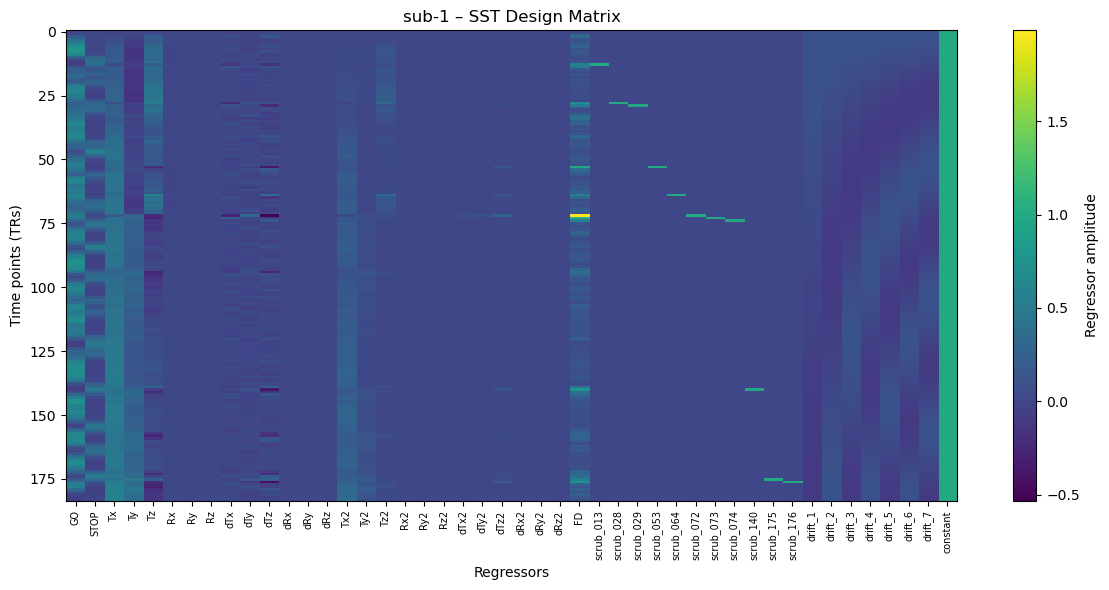

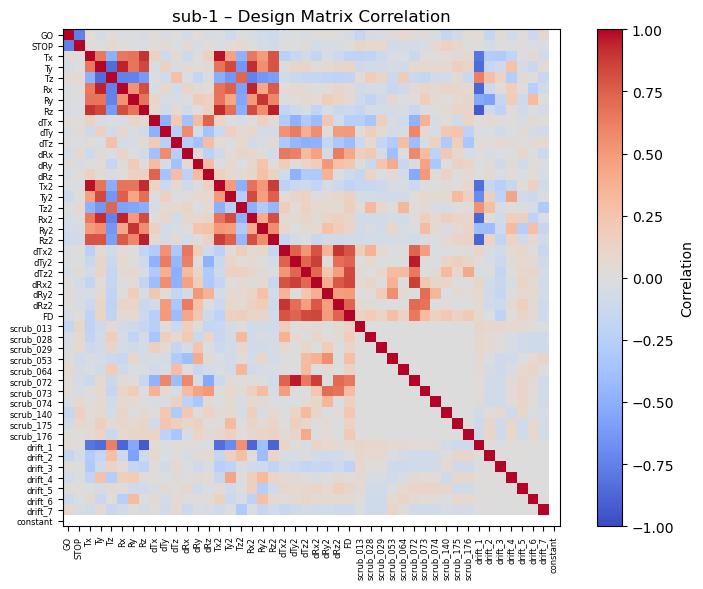


=== sub-2: Build SST design matrix ===
  BOLD shape (91, 109, 91, 184) | TR=2.00s | n_scans=184 | scan_dur=368.0s
  Trial types: ['GO', 'STOP']
  kept 128 events from 256
  design matrix shape: (184, 37)


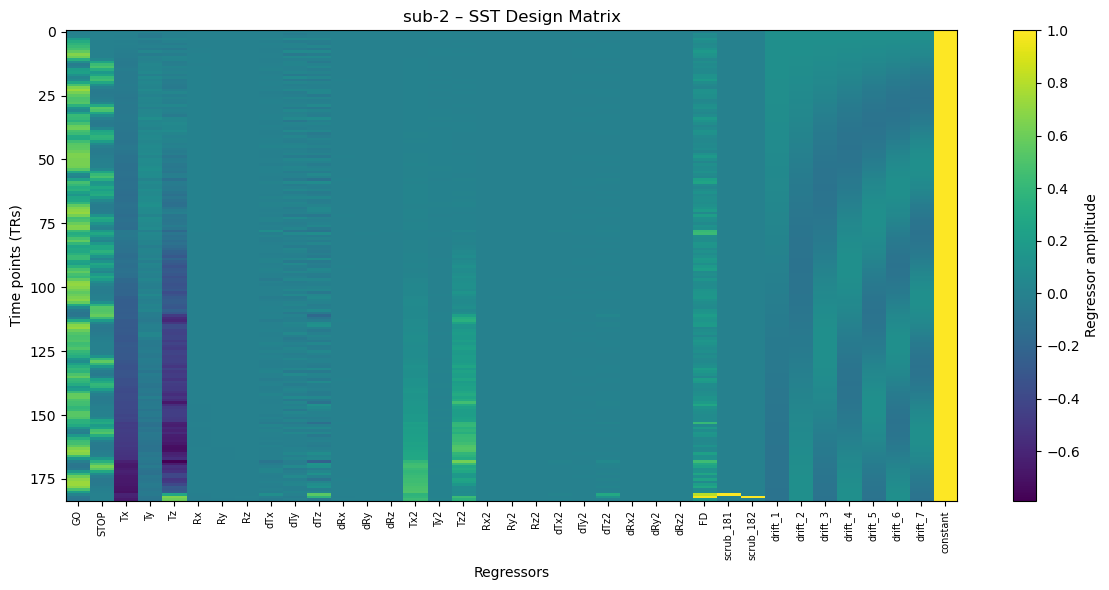

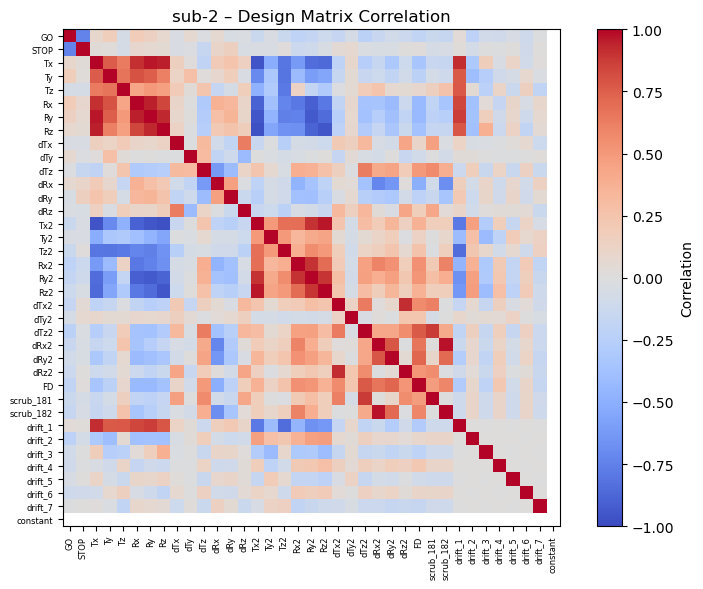

In [17]:
from pathlib import Path
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.glm.first_level import make_first_level_design_matrix

# -------- config --------
BASE = Path(r"H:\ML.neuroimaging\teaching\S 11\data.project")
SUBS = ["sub-1", "sub-2"]  # <-- both subjects here

# ---- helpers ----
def clean_events(events_df, scan_dur_s):
    """Keep onset/duration/trial_type, drop NaNs, clip within scan duration."""
    keep_cols = [c for c in ["onset", "duration", "trial_type"] if c in events_df.columns]
    ev = events_df[keep_cols].dropna(subset=["onset", "duration", "trial_type"]).copy()

    # numeric timing
    ev["onset"] = pd.to_numeric(ev["onset"], errors="coerce")
    ev["duration"] = pd.to_numeric(ev["duration"], errors="coerce")
    ev = ev.dropna(subset=["onset", "duration"])

    # stringify trial labels, trim
    ev["trial_type"] = ev["trial_type"].astype(str).str.strip()

    # clip to scan
    eps = 1e-6
    ev = ev[(ev["onset"] >= 0) & (ev["onset"] < scan_dur_s - eps)]
    max_dur = (scan_dur_s - ev["onset"] - eps).clip(lower=0)
    ev["duration"] = ev["duration"].clip(lower=0, upper=max_dur)
    return ev.reset_index(drop=True)

def align_confounds_rows(conf_df, n_scans):
    """Make confounds length match n_scans (truncate/pad zeros)."""
    r = len(conf_df)
    if r == n_scans:
        return conf_df.reset_index(drop=True)
    if r > n_scans:
        print(f"  [confounds] {r} rows > {n_scans} scans → truncating")
        return conf_df.iloc[:n_scans].reset_index(drop=True)
    # pad with zeros
    print(f"  [confounds] {r} rows < {n_scans} scans → zero-padding")
    pad = pd.DataFrame(0, index=np.arange(n_scans - r), columns=conf_df.columns)
    return pd.concat([conf_df, pad], axis=0, ignore_index=True)

# -------- run for BOTH subjects --------
for sub in SUBS:
    print(f"\n=== {sub}: Build SST design matrix ===")
    sst_dir = BASE / sub / "func" / "stopsignal_task"

    # 1) load BOLD
    bold_path = sst_dir / f"swau{sub}_task-stopsignal_bold.nii"
    img = nib.load(str(bold_path))
    n_scans = img.shape[-1]
    tr = float(img.header.get_zooms()[-1])
    frame_times = np.arange(n_scans) * tr
    scan_dur_s = n_scans * tr
    print(f"  BOLD shape {img.shape} | TR={tr:.2f}s | n_scans={n_scans} | scan_dur={scan_dur_s:.1f}s")

    # 2) events (clean)
    events_path = sst_dir / f"{sub}_task-stopsignal_events.tsv"
    raw_ev = pd.read_csv(events_path, sep="\t")
    ev = clean_events(raw_ev, scan_dur_s)
    print("  Trial types:", sorted(ev["trial_type"].unique()))
    print(f"  kept {len(ev)} events from {len(raw_ev)}")

    # 3) confounds (from Task 2) → align rows
    conf_path = sst_dir / f"{sub}_sst_confounds.tsv"
    conf = pd.read_csv(conf_path, sep="\t")
    conf = align_confounds_rows(conf, n_scans)

    # 4) design matrix (IMPORTANT: cast add_reg_names to list)
    dm = make_first_level_design_matrix(
        frame_times=frame_times,
        events=ev,
        hrf_model="spm",
        drift_model="cosine",
        add_regs=conf.values,
        add_reg_names=list(conf.columns),
    )
    print("  design matrix shape:", dm.shape)

    # 5) visualize design matrix
    plt.figure(figsize=(12, 6))
    plt.imshow(dm.values, aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar(label='Regressor amplitude')
    plt.title(f"{sub} – SST Design Matrix")
    plt.xlabel("Regressors")
    plt.ylabel("Time points (TRs)")
    plt.xticks(range(len(dm.columns)), dm.columns, rotation=90, fontsize=7)
    plt.tight_layout()
    plt.show()

    # 6) visualize regressor correlation
    corr = dm.corr()
    plt.figure(figsize=(8, 6))
    plt.imshow(corr.values, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(label='Correlation')
    plt.title(f"{sub} – Design Matrix Correlation")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=6)
    plt.yticks(range(len(corr.columns)), corr.columns, fontsize=6)
    plt.tight_layout()
    plt.show()


# 🧠 **Task 4 — Fit the First-Level GLM and Compute Contrasts**

### 🎯 **Goal**

You’ll fit a **first-level General Linear Model (GLM)** for the **Stop-Signal Task (SST)** for both subjects, then create **contrast maps** such as:

* **Stop > Go** → brain regions more active during inhibition
* **Go > Stop** → regions more active during execution

---

### 🧩 **What You’ll Do**

1. **Load**:

   * Preprocessed BOLD file (`swausub-*_task-stopsignal_bold.nii`)
   * Cleaned events (`*_task-stopsignal_events.tsv`)
   * Confounds (`*_sst_confounds.tsv`)

2. **Build and fit the model** using `FirstLevelModel` from **nilearn**:

   * HRF model: `"spm"`
   * Drift model: `"cosine"`
   * Add confound regressors.

3. **Define contrasts** using event names from your design matrix (e.g. `"STOP"`, `"GO"`).

4. **Compute contrast maps** (`Stop > Go`, `Go > Stop`) and visualize them.

5. **Interpret** which regions show stronger activation for each condition.


=== Running first-level GLM for sub-1 ===


C:\Users\Saye\AppData\Local\Temp\ipykernel_4180\816211931.py:33: UserWarning: The following unexpected columns in events data will be ignored: SubjectResponseButton, TimeCourse_noTriggerAdjust, StopSignalDelay, TimeCourse, onset_noTriggerAdjust, PresentedStimulusArrowDirection, LadderNumber, ReactionTime, SubjectResponseButtonCode, SubjectResponseCorrectness, LadderMovement, LadderTime, TrialOutcome
  fmri_glm = fmri_glm.fit(
C:\Users\Saye\AppData\Local\Temp\ipykernel_4180\816211931.py:33: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  fmri_glm = fmri_glm.fit(


Design matrix columns: ['GO', 'STOP', 'Tx', 'Ty', 'Tz', 'Rx', 'Ry', 'Rz', 'dTx', 'dTy', 'dTz', 'dRx', 'dRy', 'dRz', 'Tx2', 'Ty2', 'Tz2', 'Rx2', 'Ry2', 'Rz2', 'dTx2', 'dTy2', 'dTz2', 'dRx2', 'dRy2', 'dRz2', 'FD', 'scrub_013', 'scrub_028', 'scrub_029', 'scrub_053', 'scrub_064', 'scrub_072', 'scrub_073', 'scrub_074', 'scrub_140', 'scrub_175', 'scrub_176', 'drift_1', 'drift_2', 'drift_3', 'drift_4', 'drift_5', 'drift_6', 'drift_7', 'constant']
Task regressors found: ['GO', 'STOP']

Computing contrast: Stop>Go


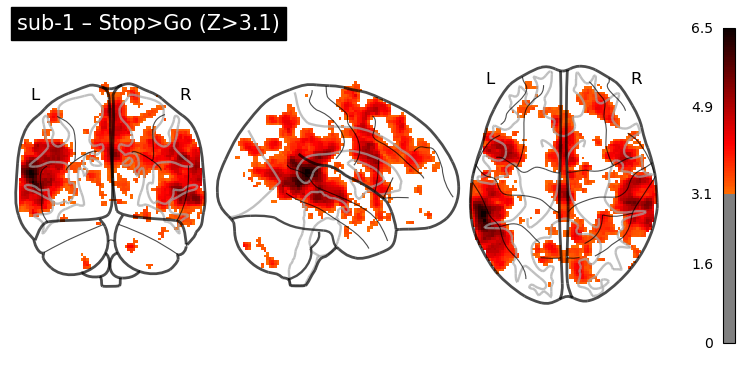

Saved: sub-1_Stop_vs_Go_zmap.nii.gz

Computing contrast: Go>Stop


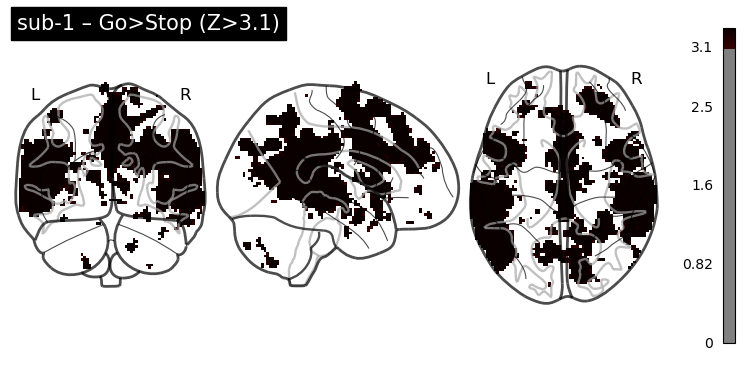

Saved: sub-1_Go_vs_Stop_zmap.nii.gz

=== Running first-level GLM for sub-2 ===


C:\Users\Saye\AppData\Local\Temp\ipykernel_4180\816211931.py:33: UserWarning: The following unexpected columns in events data will be ignored: SubjectResponseButton, TimeCourse_noTriggerAdjust, StopSignalDelay, TimeCourse, onset_noTriggerAdjust, PresentedStimulusArrowDirection, LadderNumber, ReactionTime, SubjectResponseButtonCode, SubjectResponseCorrectness, LadderMovement, LadderTime, TrialOutcome
  fmri_glm = fmri_glm.fit(
C:\Users\Saye\AppData\Local\Temp\ipykernel_4180\816211931.py:33: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  fmri_glm = fmri_glm.fit(


Design matrix columns: ['GO', 'STOP', 'Tx', 'Ty', 'Tz', 'Rx', 'Ry', 'Rz', 'dTx', 'dTy', 'dTz', 'dRx', 'dRy', 'dRz', 'Tx2', 'Ty2', 'Tz2', 'Rx2', 'Ry2', 'Rz2', 'dTx2', 'dTy2', 'dTz2', 'dRx2', 'dRy2', 'dRz2', 'FD', 'scrub_181', 'scrub_182', 'drift_1', 'drift_2', 'drift_3', 'drift_4', 'drift_5', 'drift_6', 'drift_7', 'constant']
Task regressors found: ['GO', 'STOP']

Computing contrast: Stop>Go


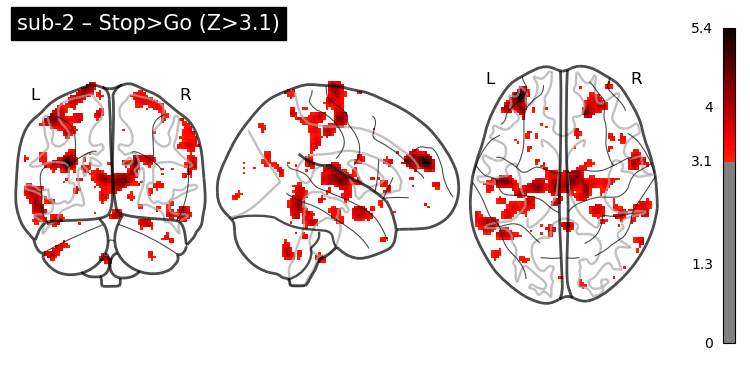

Saved: sub-2_Stop_vs_Go_zmap.nii.gz

Computing contrast: Go>Stop


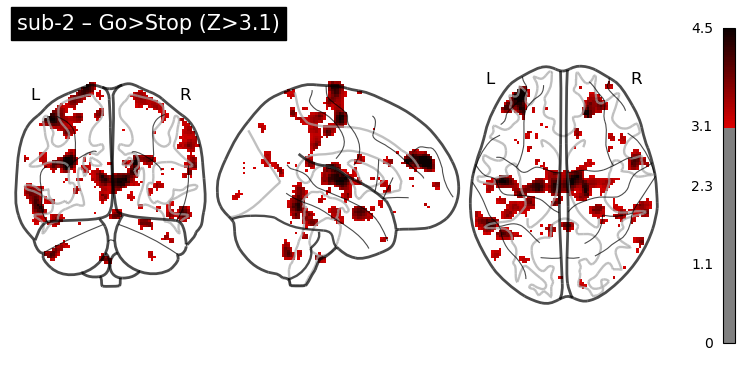

Saved: sub-2_Go_vs_Stop_zmap.nii.gz


In [19]:
from pathlib import Path
import pandas as pd
import nibabel as nib
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting

# -------- Config --------
BASE = Path(r"H:\ML.neuroimaging\teaching\S 11\data.project")
SUBS = ["sub-1", "sub-2"]

for sub in SUBS:
    print(f"\n=== Running first-level GLM for {sub} ===")
    sst_dir = BASE / sub / "func" / "stopsignal_task"

    bold_path = sst_dir / f"swau{sub}_task-stopsignal_bold.nii"
    events_path = sst_dir / f"{sub}_task-stopsignal_events.tsv"
    conf_path = sst_dir / f"{sub}_sst_confounds.tsv"

    # --- Load data ---
    events = pd.read_csv(events_path, sep="\t")
    conf = pd.read_csv(conf_path, sep="\t")

    # --- Fit the GLM ---
    fmri_glm = FirstLevelModel(
        t_r=2.0,
        hrf_model="spm",
        drift_model="cosine",
        standardize=False,
        noise_model="ar1",
        minimize_memory=False,
    )

    fmri_glm = fmri_glm.fit(
        run_imgs=bold_path,
        events=events,
        confounds=conf,
    )

    # --- Define contrasts (use your actual event names) ---
    design = fmri_glm.design_matrices_[0]
    print("Design matrix columns:", list(design.columns))

    contrast_names = [col for col in design.columns if "GO" in col or "STOP" in col]
    print("Task regressors found:", contrast_names)

    # Basic contrasts
    contrasts = {
        "Stop>Go": "STOP - GO",
        "Go>Stop": "GO - STOP",
    }

    # --- Compute contrasts and visualize ---
    for name, formula in contrasts.items():
        print(f"\nComputing contrast: {name}")
        z_map = fmri_glm.compute_contrast(formula, output_type="z_score")

        # Display statistical map
        display = plotting.plot_glass_brain(
            z_map,
            threshold=3.1,
            colorbar=True,
            title=f"{sub} – {name} (Z>3.1)",
        )
        plotting.show()

        # Optionally save for group analysis
        out_path = sst_dir / f"{sub}_{name.replace('>','_vs_')}_zmap.nii.gz"
        z_map.to_filename(out_path)
        print(f"Saved: {out_path.name}")




# 🧠 **Task 5 — Second-Level (Group) GLM Analysis**

### 🎯 **Goal**

in this task, you’ll combine the *Stop > Go* contrast maps from both subjects and run a simple **group-level GLM** (one-sample t-test).
this lets you see which brain regions show consistent activation across subjects.

---

### 🧩 **What You’ll Do**

1. **collect** the first-level *Stop > Go* contrast maps for each subject.
2. **create** a simple numeric design matrix with one column:

   * `intercept = 1` for every subject (this models the group mean).
3. **fit** a `SecondLevelModel` using nilearn.
4. **compute** the group-level contrast (`"intercept"`) and get the z-map.
5. **visualize** the group-level activation (Z > 2.3) on a glass-brain.

---

### 📈 **What You’ll See**

* a glass-brain map showing average *Stop > Go* activations across the two subjects.
* printed design-matrix summary and confirmation that the map was saved.

---

### 💬 **Interpretation**

* bright clusters show areas consistently more active during **response inhibition** (*Stop > Go*).
* these regions often include the **right inferior frontal gyrus**, **anterior cingulate**, and **pre-SMA**.
* this step demonstrates how individual-level effects are combined at the group level.



Design matrix:
    intercept
0        1.0
1        1.0


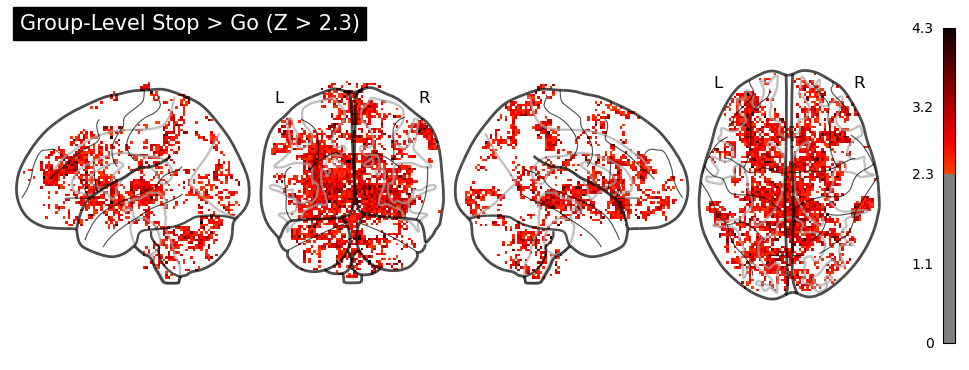

Saved group map → H:\ML.neuroimaging\teaching\S 11\data.project\group_Stop_vs_Go_zmap.nii.gz


In [22]:
from pathlib import Path
import pandas as pd
from nilearn.glm.second_level import SecondLevelModel
from nilearn import plotting

# ----- config -----
BASE = Path(r"H:\ML.neuroimaging\teaching\S 11\data.project")
SUBS = ["sub-1", "sub-2"]
contrast_name = "Stop_vs_Go"

# gather subject contrast paths
contrast_imgs = []
for sub in SUBS:
    zmap_path = BASE / sub / "func" / "stopsignal_task" / f"{sub}_{contrast_name}_zmap.nii.gz"
    contrast_imgs.append(str(zmap_path))

# simple numeric design matrix (one-sample t-test)
design_matrix = pd.DataFrame({"intercept": [1.0] * len(SUBS)})
print("Design matrix:\n", design_matrix)

# ----- fit second-level model -----
second_level_model = SecondLevelModel(smoothing_fwhm=6.0)
second_level_model = second_level_model.fit(contrast_imgs, design_matrix=design_matrix)

# compute group-level effect
z_map = second_level_model.compute_contrast("intercept", output_type="z_score")

# ----- visualize -----
plotting.plot_glass_brain(
    z_map,
    threshold=2.3,
    colorbar=True,
    display_mode="lyrz",
    title="Group-Level Stop > Go (Z > 2.3)"
)
plotting.show()

# optional: save result
out_path = BASE / f"group_{contrast_name}_zmap.nii.gz"
z_map.to_filename(out_path)
print(f"Saved group map → {out_path}")


## 🧠 Task 6 — **Task 6: Functional Connectivity (Resting-State)**

**Goal.** You will compute and visualize resting-state functional connectivity for **both subjects**:

* **ROI↔ROI** connectivity using the Harvard–Oxford atlas (Fisher-Z matrices).
* **Seed→voxel** connectivity maps from a DMN seed (posterior cingulate: *“Cingulate Gyrus, posterior division”*).

**What you do.**

1. Load the preprocessed **REST** image and your **rest confounds** (from Task 2).
2. Extract atlas **ROI time series** (band-pass filtered, standardized, detrended).
3. Compute the **ROI correlation matrix** and convert to **Fisher-Z**; visualize and save CSV.
4. Compute **seed→voxel** Fisher-Z maps; mask to **GM∩brain**, smooth, **threshold** |Z|, and apply a **cluster extent** for clean maps.
5. Plot results for **both subjects**.

**Deliverables.**

* Two ROI×ROI **Fisher-Z** heatmaps (one per subject) + CSV files.
* Two **seed maps** (one per subject) with clear, interpretable networks.

---

## 🎯 Hints for good connectivity visualizations

* **Seed choice:** For DMN, use PCC (*Cingulate Gyrus, posterior division*), **Precuneus**, or **Angular Gyrus**.
* **Thresholds:** Start with `|Z| ≥ 0.8` and `cluster ≥ 250 vox`; raise to 1.0/400 for crisper maps.
* **Smoothing:** Keep seed maps smooth but not blurry (`smoothing_fwhm ≈ 6–8 mm`).
* **Masking:** Always restrict to **gray matter** (GM) and intersect with the run’s brain mask.
* **Confounds:** Use your **24HMP + FD + scrubs** confounds from Task 2; motion spikes otherwise smear connectivity.
* **Compare subs:** Look for consistent networks (DMN nodes: PCC, medial PFC, angular gyri) and note any differences.

[fetch_atlas_harvard_oxford] Dataset found in C:\Users\Saye\nilearn_data\fsl
Atlas: 48 ROIs (background removed) | Seed: Cingulate Gyrus, posterior division (idx 29)

=== sub-1: Resting-state connectivity ===
  Rest file: swausub-1_task-rest_bold.nii | TR=2.00s | n_vols=152


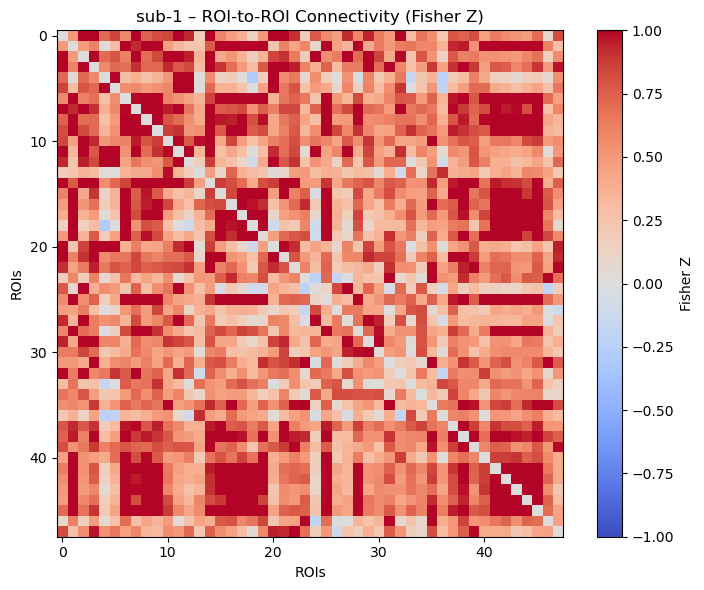

  Saved ROI×ROI Fisher-Z matrix → sub-1_HO_FisherZ.csv


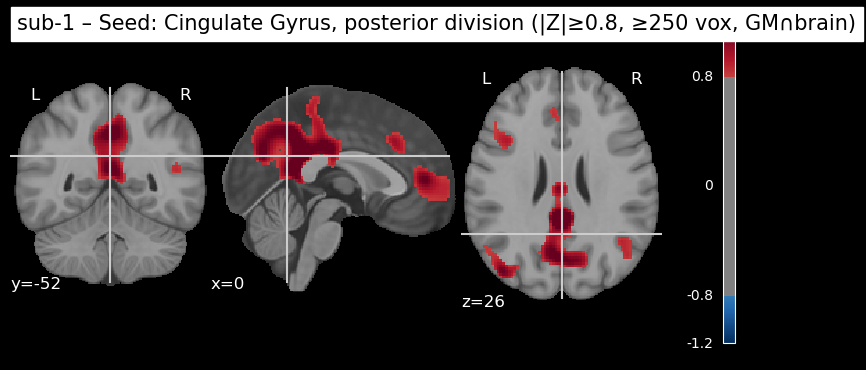


=== sub-2: Resting-state connectivity ===
  Rest file: swausub-2_task-rest_bold.nii | TR=2.00s | n_vols=152


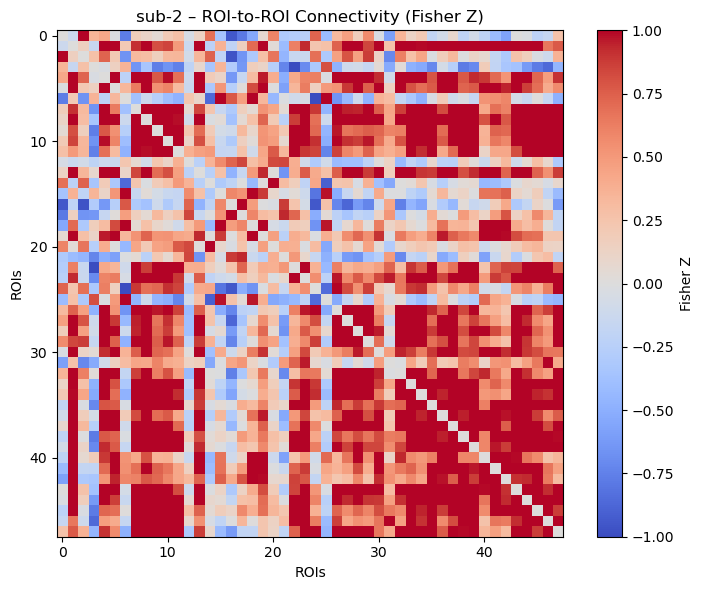

  Saved ROI×ROI Fisher-Z matrix → sub-2_HO_FisherZ.csv


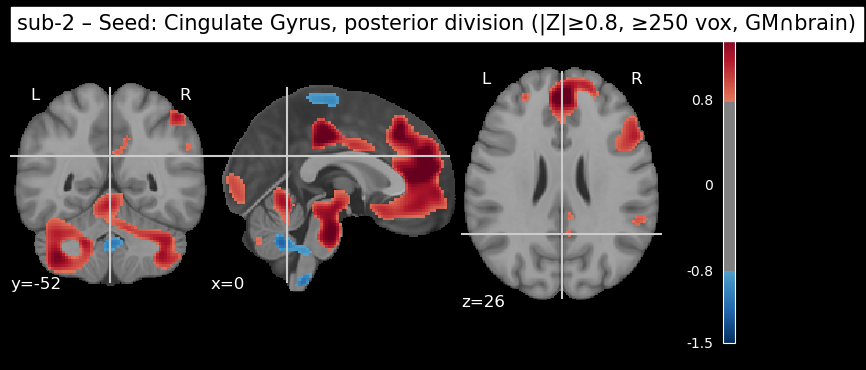

In [36]:
# ===== Task 6: Functional Connectivity (ROI↔ROI + Seed→Voxel, clean visuals) =====
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import datasets, input_data, plotting, image
from nilearn.image import resample_to_img, threshold_img, math_img, smooth_img
from nilearn.masking import apply_mask

# ---------------- CONFIG ----------------
BASE = Path(r"H:\ML.neuroimaging\teaching\S 11\data.project")
SUBS = ["sub-1", "sub-2"]                 # your two controls
ATLAS_NAME = "cort-maxprob-thr25-2mm"     # Harvard–Oxford (cortical atlas)
SEED_NAME = "Cingulate Gyrus, posterior division"  # PCC-like ROI label
LOW_PASS, HIGH_PASS = 0.08, 0.009         # standard rs-fMRI temporal filter
SMOOTH_FWHM = 6.0                          # post-mask smoothing for display
SAVE_MATRICES = True                       # save ROI×ROI Fisher-Z matrices (CSV)
Z_THR = 0.8                                # |Z| threshold for seed maps (0.8–1.1 is usual)
CL_SIZE = 250                              # min cluster extent (voxels) for cleanup

# ---------------- HELPERS ----------------
def find_one(folder: Path, pattern: str) -> Path:
    hits = sorted(folder.glob(pattern))
    if not hits:
        raise FileNotFoundError(f"No file matching '{pattern}' in {folder}")
    return hits[0]

def fisher_z(arr):
    arr = np.clip(arr, -0.999999, 0.999999)
    return np.arctanh(arr)

def pick_roi_index(labels_no_bg, name_substring):
    idx = [i for i, lab in enumerate(labels_no_bg) if name_substring.lower() in lab.lower()]
    if not idx:
        raise ValueError(f"No ROI matched '{name_substring}'. Try another substring (e.g., 'Precuneus', 'Angular').")
    return idx[0]

# ------------- LOAD ATLAS (drop “Background”) -------------
ho = datasets.fetch_atlas_harvard_oxford(ATLAS_NAME)
atlas_img = ho.maps
labels_full = list(ho.labels)      # includes 'Background' at index 0
labels = labels_full[1:]           # drop background so labels align with masker's columns
seed_idx = pick_roi_index(labels, SEED_NAME)
print(f"Atlas: {len(labels)} ROIs (background removed) | Seed: {labels[seed_idx]} (idx {seed_idx})")

# nice anatomical background
bg = datasets.load_mni152_template()

# ---------------- MAIN LOOP (BOTH SUBJECTS) ----------------
for sub in SUBS:
    print(f"\n=== {sub}: Resting-state connectivity ===")
    rest_dir = BASE / sub / "func" / "rest"
    rest_img = find_one(rest_dir, "*rest*.nii*")
    conf_path = rest_dir / f"{sub}_rest_confounds.tsv"
    conf = pd.read_csv(conf_path, sep="\t")

    img = image.load_img(rest_img)
    tr = float(img.header.get_zooms()[-1])
    n_vols = img.shape[-1]
    print(f"  Rest file: {rest_img.name} | TR={tr:.2f}s | n_vols={n_vols}")

    # ---- ROI time series (Harvard–Oxford labels, no background) ----
    labels_masker = input_data.NiftiLabelsMasker(
        labels_img=atlas_img,
        standardize=True, detrend=True,
        low_pass=LOW_PASS, high_pass=HIGH_PASS,
        t_r=tr
    )
    roi_ts = labels_masker.fit_transform(img, confounds=conf)  # T × N (N=len(labels))
    if roi_ts.shape[1] != len(labels):
        raise RuntimeError(f"ROI TS columns ({roi_ts.shape[1]}) != labels ({len(labels)}).")

    # ---- ROI↔ROI connectivity (Fisher-Z) ----
    corr = np.corrcoef(roi_ts, rowvar=False)  # N × N Pearson r
    np.fill_diagonal(corr, 0)
    z = fisher_z(corr)

    # visualize matrix
    plt.figure(figsize=(7.5, 6))
    plt.imshow(z, vmin=-1.0, vmax=1.0, cmap="coolwarm", interpolation="nearest")
    plt.title(f"{sub} – ROI-to-ROI Connectivity (Fisher Z)")
    plt.xlabel("ROIs"); plt.ylabel("ROIs")
    plt.colorbar(label="Fisher Z")
    plt.tight_layout(); plt.show()

    # optionally save matrix
    if SAVE_MATRICES:
        z_df = pd.DataFrame(z, index=labels, columns=labels)
        z_out = rest_dir / f"{sub}_HO_FisherZ.csv"
        z_df.to_csv(z_out)
        print(f"  Saved ROI×ROI Fisher-Z matrix → {z_out.name}")

    # ---- Seed→Voxel connectivity (clean visualization) ----
    seed_ts = roi_ts[:, seed_idx]  # T,

    # voxelwise masker (heavier smoothing to reduce speckle)
    brain_masker = input_data.NiftiMasker(
        standardize=True, detrend=True,
        low_pass=LOW_PASS, high_pass=HIGH_PASS,
        smoothing_fwhm=8.0, t_r=tr
    ).fit(img)

    voxel_ts = brain_masker.transform(img, confounds=conf)  # T × V

    # robust voxelwise correlation with seed (r then Fisher-Z)
    r = (voxel_ts * seed_ts[:, None]).mean(axis=0) / (voxel_ts.std(axis=0) * seed_ts.std() + 1e-8)
    z_vox = fisher_z(r)
    z_img = brain_masker.inverse_transform(z_vox)

    # GM∩brain masking in run space (avoid FoV mismatch by resampling)
    brain_mask = brain_masker.mask_img_
    gm_mni = datasets.load_mni152_gm_mask()
    gm_run = resample_to_img(gm_mni, brain_mask, interpolation="nearest",
                             force_resample=True, copy_header=True)
    gm_brain = math_img("gm * brain", gm=gm_run, brain=brain_mask)

    # apply mask + smooth for display
    z_img = math_img("img * m", img=z_img, m=gm_brain)
    z_img = smooth_img(z_img, fwhm=SMOOTH_FWHM)

    # cluster cleanup and threshold
    z_thr = threshold_img(z_img, threshold=Z_THR, two_sided=True,
                          cluster_threshold=CL_SIZE, copy_header=True)

    # robust color scaling from masked data
    z_vals = apply_mask(z_img, gm_brain)
    vmax = float(np.percentile(np.abs(z_vals[np.isfinite(z_vals)]), 99.5)) or 1.0

    plotting.plot_stat_map(
        z_thr, bg_img=bg, threshold=Z_THR, vmax=vmax,
        display_mode="ortho", cut_coords=(0, -52, 26),
        symmetric_cbar=True,
        title=f"{sub} – Seed: {labels[seed_idx]} (|Z|≥{Z_THR}, ≥{CL_SIZE} vox, GM∩brain)"
    )
    plotting.show()




# 🧠 Task 7 — Group-Level Connectivity

### 🎯 Goal

Combine both subjects’ resting-state connectivity to see **group patterns**:

1. the **average ROI↔ROI Fisher-Z matrix**
2. a **group seed→voxel DMN map**
3. a simple **network graph** of strongest connections

### 🧩 What you’ll do

* Load each subject’s ROI matrices from Task 6 (`*_HO_FisherZ.csv`) and average them.
* Recompute the seed map per subject (same seed as Task 6), then average Z across subjects (and show a clean thresholded map).
* Build a tiny **graph** from the average matrix, focusing on a few DMN ROIs (PCC/Precuneus/Angular/Frontal-Medial).

### 📦 Deliverables

* Heatmap of **group average Fisher-Z** (ROI↔ROI).
* **Group DMN seed map** (clean threshold).
* **Network graph** showing strongest average edges among selected ROIs.

## 💡 Hints for great group visualizations

* **Keep the same atlas & seed** as Task 6, so group maps are comparable.
* **Thresholds matter:** for clean group maps, try `|Z| ≥ 0.9–1.1` and `cluster ≥ 300–500 vox`.
* **Small graphs > big hairballs:** pick a handful of ROIs (e.g., PCC, Precuneus, Angular, Frontal-Medial) and plot only the **top N edges by |Z|**.
* **Tell the story:** DMN should show links PCC↔Precuneus↔Angular↔mPFC; mention symmetry/lateralization and any subject differences.
* **QC first:** messy maps often mean motion. Revisit Task 2 (FD + scrubs) if results look noisy.

C:\Users\Saye\AppData\Local\Temp\ipykernel_19472\2482961334.py:7: DeprecationWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  from nilearn import datasets, input_data, plotting, image


[fetch_atlas_harvard_oxford] Dataset found in C:\Users\Saye\nilearn_data\fsl


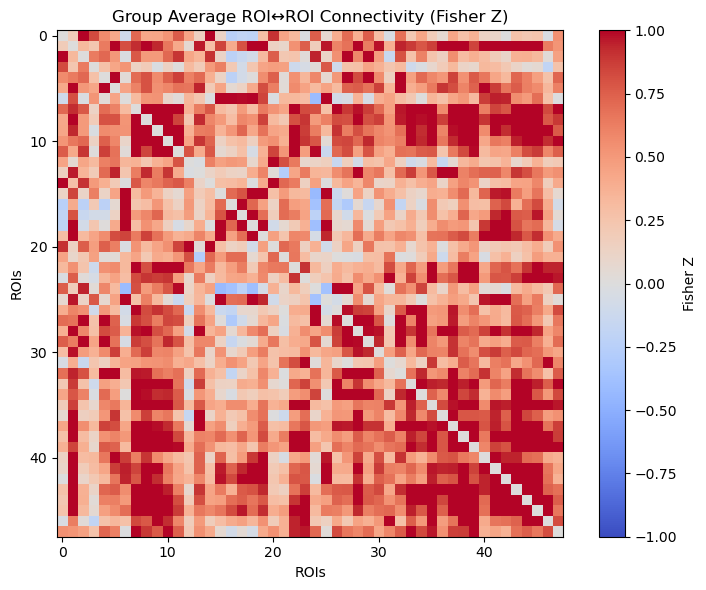

C:\Users\Saye\AppData\Local\Temp\ipykernel_19472\2482961334.py:119: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  z_mean = image.mean_img(z_imgs)


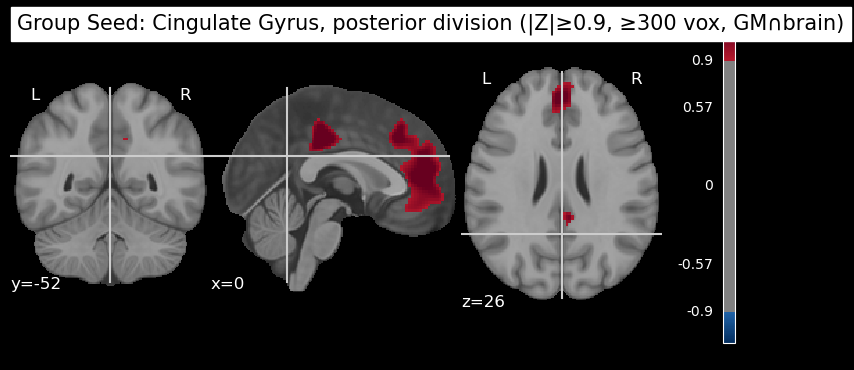

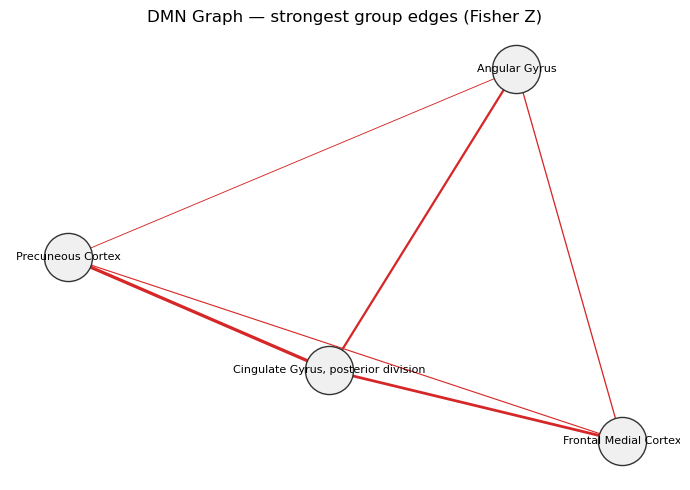

In [1]:
# ===== Task 7: Group-level connectivity =====
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nilearn import datasets, input_data, plotting, image
from nilearn.image import resample_to_img, threshold_img, math_img, smooth_img
from nilearn.masking import apply_mask
import networkx as nx  # if missing, pip install networkx

# ---------------- CONFIG ----------------
BASE = Path(r"H:\ML.neuroimaging\teaching\S 11\data.project")
SUBS = ["sub-1", "sub-2"]
ATLAS_NAME = "cort-maxprob-thr25-2mm"
SEED_NAME = "Cingulate Gyrus, posterior division"  # PCC-like
LOW_PASS, HIGH_PASS = 0.08, 0.009
SMOOTH_FWHM = 6.0
Z_THR = 0.9          # group seed-map |Z| threshold (increase for cleaner map)
CL_SIZE = 300        # cluster extent in voxels
GRAPH_TOP_EDGES = 20 # show N strongest edges in graph

# ---------------- HELPERS ----------------
def fisher_z(arr):
    arr = np.clip(arr, -0.999999, 0.999999)
    return np.arctanh(arr)

def find_one(folder: Path, pattern: str) -> Path:
    hits = sorted(folder.glob(pattern))
    if not hits:
        raise FileNotFoundError(f"No file matching '{pattern}' in {folder}")
    return hits[0]

def load_avg_roi_matrix(labels):
    """Load each subject's Fisher-Z CSV (Task 6 outputs) and average."""
    mats = []
    for sub in SUBS:
        rest_dir = BASE / sub / "func" / "rest"
        f = rest_dir / f"{sub}_HO_FisherZ.csv"
        Z = pd.read_csv(f, index_col=0).reindex(index=labels, columns=labels).values
        mats.append(Z)
    return np.mean(mats, axis=0)

def compute_subject_seed_z(sub, seed_idx, labels, atlas_img, bg):
    """Recompute per-subject seed→voxel Z (same preprocessing as Task 6)."""
    rest_dir = BASE / sub / "func" / "rest"
    rest_img = find_one(rest_dir, "*rest*.nii*")
    conf = pd.read_csv(rest_dir / f"{sub}_rest_confounds.tsv", sep="\t")
    img = image.load_img(rest_img)
    tr = float(img.header.get_zooms()[-1])

    # ROI ts for seed extraction
    labels_masker = input_data.NiftiLabelsMasker(
        labels_img=atlas_img, standardize=True, detrend=True,
        low_pass=LOW_PASS, high_pass=HIGH_PASS, t_r=tr
    )
    roi_ts = labels_masker.fit_transform(img, confounds=conf)  # T×N (N=len(labels))
    seed_ts = roi_ts[:, seed_idx]

    # Voxelwise masker + signals
    brain_masker = input_data.NiftiMasker(
        standardize=True, detrend=True,
        low_pass=LOW_PASS, high_pass=HIGH_PASS,
        smoothing_fwhm=8.0, t_r=tr
    ).fit(img)
    voxel_ts = brain_masker.transform(img, confounds=conf)  # T×V

    # Pearson r with seed, then Fisher-Z
    r = (voxel_ts * seed_ts[:, None]).mean(axis=0) / (voxel_ts.std(axis=0) * seed_ts.std() + 1e-8)
    z_vox = fisher_z(r)
    z_img = brain_masker.inverse_transform(z_vox)

    # GM∩brain masking in run space
    brain_mask = brain_masker.mask_img_
    gm_mni = datasets.load_mni152_gm_mask()
    gm_run = resample_to_img(gm_mni, brain_mask, interpolation="nearest",
                             force_resample=True, copy_header=True)
    gm_brain = math_img("gm * brain", gm=gm_run, brain=brain_mask)

    # apply mask + smooth for display
    z_img = math_img("img * m", img=z_img, m=gm_brain)
    z_img = smooth_img(z_img, fwhm=SMOOTH_FWHM)
    return z_img, gm_brain

# ------------- ATLAS + LABELS -------------
ho = datasets.fetch_atlas_harvard_oxford(ATLAS_NAME)
atlas_img = ho.maps
labels_full = list(ho.labels)      # includes "Background"
labels = labels_full[1:]           # drop background
# pick seed index from label substring
seed_idx = [i for i,l in enumerate(labels) if SEED_NAME.lower() in l.lower()][0]
bg = datasets.load_mni152_template()

# ========== 1) GROUP AVERAGE ROI↔ROI MATRIX ==========
Zavg = load_avg_roi_matrix(labels)

plt.figure(figsize=(7.8, 6))
plt.imshow(Zavg, vmin=-1.0, vmax=1.0, cmap="coolwarm", interpolation="nearest")
plt.title("Group Average ROI↔ROI Connectivity (Fisher Z)")
plt.xlabel("ROIs"); plt.ylabel("ROIs")
plt.colorbar(label="Fisher Z")
plt.tight_layout(); plt.show()

# ========== 2) GROUP SEED→VOXEL MAP ==========
# compute each subject's Z image, then average voxelwise
z_imgs = []
gm_masks = []
for sub in SUBS:
    z_img, gm_brain = compute_subject_seed_z(sub, seed_idx, labels, atlas_img, bg)
    z_imgs.append(z_img)
    gm_masks.append(gm_brain)

# intersect GM masks across subjects (same grid assumed per subject run)
gm_group = gm_masks[0]
for m in gm_masks[1:]:
    gm_group = math_img("a * b", a=gm_group, b=m)

# average Z images
z_mean = image.mean_img(z_imgs)
# threshold + cluster cleanup
z_thr = threshold_img(z_mean, threshold=Z_THR, two_sided=True,
                      cluster_threshold=CL_SIZE, copy_header=True)

# robust color scaling from masked group data
z_vals = apply_mask(z_mean, gm_group)
vmax = float(np.percentile(np.abs(z_vals[np.isfinite(z_vals)]), 99.5)) or 1.0

plotting.plot_stat_map(
    z_thr, bg_img=bg, threshold=Z_THR, vmax=vmax,
    display_mode="ortho", cut_coords=(0, -52, 26),
    symmetric_cbar=True,
    title=f"Group Seed: {labels[seed_idx]} (|Z|≥{Z_THR}, ≥{CL_SIZE} vox, GM∩brain)"
)
plotting.show()

# ========== 3) SIMPLE NETWORK / GRAPH VIEW ==========
# Choose a small DMN set (use atlas labels, bilateral regions)
dmn_names = [
    "Cingulate Gyrus, posterior division",  # PCC
    "Precuneous Cortex",
    "Angular Gyrus",
    "Frontal Medial Cortex",
]
dmn_idx = [i for i,l in enumerate(labels) if any(n.lower() in l.lower() for n in dmn_names)]
dmn_labels = [labels[i] for i in dmn_idx]

# pull submatrix and take strongest edges
Zsub = Zavg[np.ix_(dmn_idx, dmn_idx)]
np.fill_diagonal(Zsub, 0)
# get upper triangle edges
pairs = []
for i in range(Zsub.shape[0]):
    for j in range(i+1, Zsub.shape[1]):
        pairs.append((i, j, Zsub[i, j]))
# top by absolute Fisher-Z
pairs_sorted = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)[:GRAPH_TOP_EDGES]

# build graph
G = nx.Graph()
for i, name in enumerate(dmn_labels):
    G.add_node(i, label=name)
for i, j, w in pairs_sorted:
    G.add_edge(i, j, weight=float(w))

# draw
plt.figure(figsize=(7, 5))
pos = nx.spring_layout(G, seed=42, k=0.7)
# edge widths scaled by |Z|
weights = [2.5 * abs(G[u][v]['weight']) for u,v in G.edges()]
nx.draw_networkx_nodes(G, pos, node_color="#f0f0f0", edgecolors="#333", node_size=1200)
nx.draw_networkx_labels(G, pos, labels={i:l for i,l in enumerate(dmn_labels)}, font_size=8)
nx.draw_networkx_edges(G, pos, width=weights, edge_color="#d62728")  # red-ish
plt.title("DMN Graph — strongest group edges (Fisher Z)")
plt.axis("off"); plt.tight_layout(); plt.show()



# 🧠 Task 8 — Activation-informed Connectivity (short version)

### 🎯 Goal

You’ll use your **Stop>Go** activation to define a **right IFG** seed and examine its **resting-state connectivity**.

### What you do

1. **Find the IFG seed:**

   * Load each subject’s *Stop>Go* z-map.
   * Resample the Harvard–Oxford atlas to the z-map space and make an IFG mask (triangularis + opercularis).
   * Pick the peak in the **right** IFG; if none, use a canonical R-IFG coordinate.
   * Build a **6-mm sphere** at that location.

2. **Compute REST seed→voxel FC (per subject):**

   * Extract the seed time series in REST with band-pass (0.009–0.08 Hz), detrend, and standardize; regress your **Task 2** confounds.
   * Correlate the seed with every voxel → convert to **Fisher-Z**.
   * Restrict to **GM ∩ brain mask** (in the run’s space), lightly **smooth**, and apply **|Z| threshold + cluster extent** for clean maps.

3. **Group result:**

   * Average the per-subject Z-maps → show a **group IFG connectivity map** (cleanly thresholded).
   * Also extract a small table of **IFG ↔ DMN ROIs** (PCC, Precuneus, Angular) in Fisher-Z for each subject.

### Outputs

* IFG seed coordinate (MNI) for each subject.
* Group **IFG seed map** (clean, thresholded).
* Tiny **IFG↔DMN Fisher-Z** table.

### Quick tips

* If maps look busy, raise the threshold (e.g., **|Z| ≥ 1.0**) and the cluster size (e.g., **≥ 400 vox**).
* Strong confound regression (24HMP + FD + scrubs) is essential for stable connectivity.
* Interpret: does R-IFG connect with **pre-SMA**, **parietal**, **basal ganglia** at rest, consistent with inhibitory-control networks?


[fetch_atlas_harvard_oxford] Dataset found in C:\Users\Saye\nilearn_data\fsl
sub-1 IFG seed (MNI mm): (46.0, 14.0, 28.0)
sub-2 IFG seed (MNI mm): (46.0, 18.0, 8.0)


C:\Users\Saye\AppData\Local\Temp\ipykernel_19472\698317483.py:159: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  z_mean = image.mean_img(z_imgs)


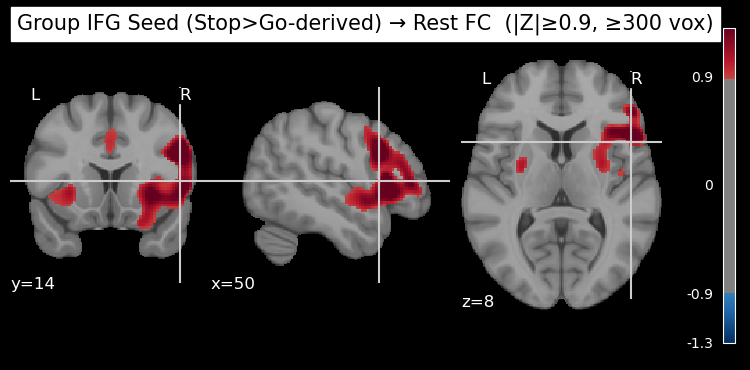


IFG (Stop>Go seed) ↔ DMN ROIs — Fisher-Z


roi,Angular Gyrus,"Cingulate Gyrus, posterior division",Precuneous Cortex
subject,,,
sub-1,0.74,0.45,0.40
sub-2,-0.02,1.05,1.05


In [3]:
# ===== Task 8: Activation-informed connectivity (R IFG from Stop>Go → Rest FC) =====
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nilearn import datasets, input_data, image, plotting
from nilearn.image import resample_to_img, math_img, threshold_img, smooth_img
from nilearn.maskers import NiftiSpheresMasker  # if nilearn<0.10, use from nilearn.input_data import NiftiSpheresMasker
from nilearn.masking import apply_mask
import nibabel as nib

# ---------------- CONFIG ----------------
BASE = Path(r"H:\ML.neuroimaging\teaching\S 11\data.project")
SUBS = ["sub-1", "sub-2"]
CON_NAME = "Stop_vs_Go"                         # from Task 4 saved z-maps
ATLAS_NAME = "cort-maxprob-thr25-2mm"          # Harvard–Oxford (cortical)
FALLBACK_RIFG = (50, 16, 6)                    # canonical right IFG MNI (mm)
SPHERE_MM = 6
LOW_PASS, HIGH_PASS = 0.08, 0.009
SMOOTH_FWHM = 6.0
Z_THR = 0.9
CL_SIZE = 300

DMN_ROI_NAMES = [
    "Cingulate Gyrus, posterior division",   # PCC
    "Precuneous Cortex",                     # Precuneus (atlas spelling)
    "Angular Gyrus",                         # Angular
]

# ---------------- HELPERS ----------------
def fisher_z(arr):
    arr = np.clip(arr, -0.999999, 0.999999)
    return np.arctanh(arr)

def find_one(folder: Path, pattern: str) -> Path:
    hits = sorted(folder.glob(pattern))
    if not hits:
        raise FileNotFoundError(f"No file matching '{pattern}' in {folder}")
    return hits[0]

def pick_label_index(labels, name_substring):
    m = [i for i, l in enumerate(labels) if name_substring.lower() in l.lower()]
    if not m:
        raise ValueError(f"ROI not found: '{name_substring}'")
    return m[0]

def choose_rifg_peak(z_map_img, ho_img):
    """
    Pick a right-hemisphere IFG peak from the Stop>Go z-map.
    - Resamples HO atlas to the z-map space (avoids affine/shape mismatch).
    - Uses IFG triangularis/opercularis labels (5,6) from HO cortical atlas.
    - If no suprathreshold voxels, falls back to a canonical R-IFG coordinate.
    """
    # 1) resample atlas to z-map space (keep integer labels via 'nearest')
    ho_in_z = resample_to_img(ho_img, z_map_img, interpolation="nearest",
                              force_resample=True, copy_header=True)
    # 2) IFG mask (note: HO is unlateralized; we pick right by x>0 later)
    ifg_mask = math_img("(img==5) + (img==6)", img=ho_in_z)
    z_ifg = math_img("z * (m>0)", z=z_map_img, m=ifg_mask)

    # 3) get 3D data and restrict to RIGHT hemisphere (world x > 0)
    data = z_ifg.get_fdata()
    aff = z_ifg.affine
    nx = data.shape[0]
    xs = np.arange(nx)
    # approximate world-x for each i (assumes low shear):
    world_x = aff[0, 0] * xs + aff[0, 3]
    right_idx = world_x > 0
    if not right_idx.any():
        # unexpected, but guard anyway
        right_idx = xs > xs.mean()

    # zero-out left side
    data_left_zeroed = data.copy()
    data_left_zeroed[~right_idx, :, :] = -np.inf

    # 4) pick max z within right IFG; fallback if empty/NaN
    if not np.isfinite(data_left_zeroed).any():
        return FALLBACK_RIFG

    flat_idx = np.nanargmax(data_left_zeroed)
    i, j, k = np.unravel_index(flat_idx, data.shape)
    xyz = nib.affines.apply_affine(aff, [i, j, k])
    # ensure positive x
    x, y, z = xyz
    if x <= 0:
        x = abs(x)
    return (float(x), float(y), float(z))

def subject_seed_map_from_rest(sub, seed_xyz, bg, ho_img):
    """Compute IFG-seed→voxel Fisher-Z map for REST with GM∩brain masking."""
    rest_dir = BASE / sub / "func" / "rest"
    rest_img = find_one(rest_dir, "*rest*.nii*")
    conf = pd.read_csv(rest_dir / f"{sub}_rest_confounds.tsv", sep="\t")
    img = image.load_img(rest_img)
    tr = float(img.header.get_zooms()[-1])

    # seed sphere time series
    spheres = NiftiSpheresMasker([seed_xyz], radius=SPHERE_MM,
                                 standardize=True, detrend=True,
                                 low_pass=LOW_PASS, high_pass=HIGH_PASS, t_r=tr)
    seed_ts = spheres.fit_transform(img, confounds=conf).ravel()

    # voxelwise masker
    brain_masker = input_data.NiftiMasker(
        standardize=True, detrend=True,
        low_pass=LOW_PASS, high_pass=HIGH_PASS,
        smoothing_fwhm=8.0, t_r=tr
    ).fit(img)
    voxel_ts = brain_masker.transform(img, confounds=conf)  # T×V

    # r → Z
    r = (voxel_ts * seed_ts[:, None]).mean(axis=0) / (voxel_ts.std(axis=0) * seed_ts.std() + 1e-8)
    z_vox = fisher_z(r)
    z_img = brain_masker.inverse_transform(z_vox)

    # GM∩brain mask in run space
    brain_mask = brain_masker.mask_img_
    gm_mni = datasets.load_mni152_gm_mask()
    gm_run = resample_to_img(gm_mni, brain_mask, interpolation="nearest",
                             force_resample=True, copy_header=True)
    gm_brain = math_img("gm * brain", gm=gm_run, brain=brain_mask)

    # apply mask + smooth
    z_img = math_img("img * m", img=z_img, m=gm_brain)
    z_img = smooth_img(z_img, fwhm=SMOOTH_FWHM)
    return z_img, gm_brain

# ---------------- LOAD ATLAS / LABELS ----------------
ho = datasets.fetch_atlas_harvard_oxford(ATLAS_NAME)
ho_img = ho.maps
labels_full = list(ho.labels)      # includes "Background"
labels = labels_full[1:]           # drop it
bg = datasets.load_mni152_template()

# ---------------- 1) GET IFG SEED PER SUBJECT FROM Stop>Go ----------------
sub_seeds = {}
for sub in SUBS:
    zmap_path = BASE / sub / "func" / "stopsignal_task" / f"{sub}_{CON_NAME}_zmap.nii.gz"
    zmap = image.load_img(zmap_path)
    seed_xyz = choose_rifg_peak(zmap, ho_img)
    sub_seeds[sub] = seed_xyz
    print(f"{sub} IFG seed (MNI mm): {seed_xyz}")

# ---------------- 2) REST SEED→VOXEL MAPS, THEN GROUP AVERAGE ----------------
z_imgs, gm_masks = [], []
for sub in SUBS:
    z_img, gm_brain = subject_seed_map_from_rest(sub, sub_seeds[sub], bg, ho_img)
    z_imgs.append(z_img)
    gm_masks.append(gm_brain)

# intersect GM masks
gm_group = gm_masks[0]
for m in gm_masks[1:]:
    gm_group = math_img("a * b", a=gm_group, b=m)

# group average
z_mean = image.mean_img(z_imgs)

# threshold + cluster cleanup
z_thr = threshold_img(z_mean, threshold=Z_THR, two_sided=True,
                      cluster_threshold=CL_SIZE, copy_header=True)

# robust color scale
z_vals = apply_mask(z_mean, gm_group)
vmax = float(np.percentile(np.abs(z_vals[np.isfinite(z_vals)]), 99.5)) or 1.0

plotting.plot_stat_map(
    z_thr, bg_img=bg, threshold=Z_THR, vmax=vmax,
    display_mode="ortho", cut_coords=(50, 14, 8),  # near R IFG; tweak
    symmetric_cbar=True,
    title=f"Group IFG Seed (Stop>Go-derived) → Rest FC  (|Z|≥{Z_THR}, ≥{CL_SIZE} vox)"
)
plotting.show()

# ---------------- 3) IFG ↔ DMN ROI Fisher-Z table ----------------
# extract ROI time-series and compute IFG↔DMN Z per subject
rows = []
for sub in SUBS:
    rest_dir = BASE / sub / "func" / "rest"
    rest_img = find_one(rest_dir, "*rest*.nii*")
    conf = pd.read_csv(rest_dir / f"{sub}_rest_confounds.tsv", sep="\t")
    img = image.load_img(rest_img)
    tr = float(img.header.get_zooms()[-1])

    # atlas ROI time series
    labels_masker = input_data.NiftiLabelsMasker(
        labels_img=ho_img, standardize=True, detrend=True,
        low_pass=LOW_PASS, high_pass=HIGH_PASS, t_r=tr
    )
    roi_ts = labels_masker.fit_transform(img, confounds=conf)  # T×N (N=len(labels))

    # seed ts
    spheres = NiftiSpheresMasker([sub_seeds[sub]], radius=SPHERE_MM,
                                 standardize=True, detrend=True,
                                 low_pass=LOW_PASS, high_pass=HIGH_PASS, t_r=tr)
    seed_ts = spheres.fit_transform(img, confounds=conf).ravel()

    # DMN ROI indices
    roi_idxs = [pick_label_index(labels, n) for n in DMN_ROI_NAMES]
    dmn_labels = [labels[i] for i in roi_idxs]

    for idx, lab in zip(roi_idxs, dmn_labels):
        r = np.corrcoef(seed_ts, roi_ts[:, idx])[0, 1]
        rows.append({"subject": sub, "roi": lab, "FisherZ": float(fisher_z(r))})

table = pd.DataFrame(rows).pivot(index="subject", columns="roi", values="FisherZ").round(2)
print("\nIFG (Stop>Go seed) ↔ DMN ROIs — Fisher-Z")
table


# 🧠 Task 9 — PPI-lite during the SST (Right IFG seed)

### 🎯 Goal

Estimate **task-modulated connectivity**: how the **right IFG’s** coupling changes for **STOP vs GO** during the Stop-Signal Task.

### 🧩 What you do

1. **Pick the seed (R-IFG)** 🔎
   Use each subject’s **Stop>Go** z-map to find a right IFG peak; if none, use a **canonical R-IFG** MNI coordinate. Create a **6-mm sphere** at that spot.

2. **Build the regressors** 🧪

   * **Physio:** IFG seed time series from the SST run (standardized, band-pass filtered, confounds regressed).
   * **Psycho:** task regressor **STOP − GO** (HRF-convolved, then z-scored).
   * **PPI:** interaction **z(Physio) × z(Psycho)**.

3. **Fit the GLM** ⚙️
   Use a custom first-level design with **STOP**, **GO**, **seed (IFG)**, **PPI**, **cosine drifts**, and your **confounds** (24HMP + FD + scrubs).

4. **Test the interaction** 📊
   Contrast the **PPI** column to get a **PPI z-map** showing voxels whose coupling with IFG **differs for STOP vs GO**.

### 📦 What you hand in

* A **thresholded PPI z-map** per subject (figure).
* **2–3 sentences** interpreting the pattern (key regions, lateralization, strength).
* **1 sentence** comparing to **resting connectivity** (Tasks 6–7): what’s stable vs task-specific?

### 🔍 How to read the map

* **Positive PPI** ➕: stronger IFG coupling during **STOP** (expect **pre-SMA**, **basal ganglia**, **parietal** nodes).
* **Negative PPI** ➖: stronger coupling during **GO** (execution/motor circuits).

### ✅ Quality tips

* Reuse strong **confounds** from earlier tasks — motion spikes can distort PPI.
* If noisy, raise the **Z-threshold** (e.g., 3.1 → 3.5) or add a **cluster extent**.
* No clear IFG peak? Use the **canonical R-IFG** seed and note it in your write-up.


[fetch_atlas_harvard_oxford] Dataset found in C:\Users\Saye\nilearn_data\fsl

=== sub-1: PPI-lite during SST ===
  R-IFG seed from Stop>Go: (46.0, 14.0, 28.0)


C:\Users\Saye\AppData\Local\Temp\ipykernel_19472\2590264183.py:138: UserWarning: If design matrices are supplied, [drift_model, hrf_model, t_r] will be ignored.
  glm = glm.fit(run_imgs=img, design_matrices=[dm])


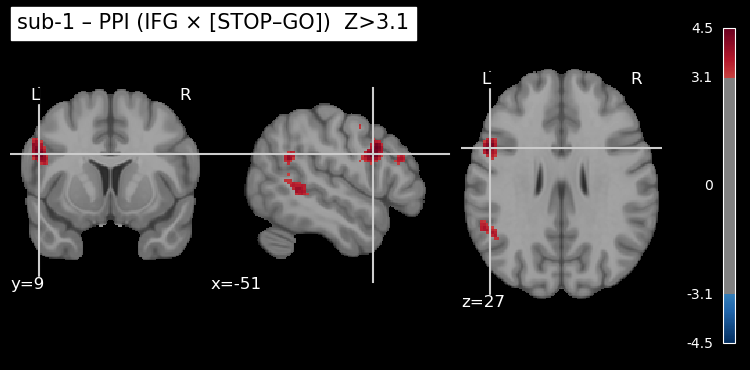


=== sub-2: PPI-lite during SST ===
  R-IFG seed from Stop>Go: (46.0, 18.0, 8.0)


C:\Users\Saye\AppData\Local\Temp\ipykernel_19472\2590264183.py:138: UserWarning: If design matrices are supplied, [drift_model, hrf_model, t_r] will be ignored.
  glm = glm.fit(run_imgs=img, design_matrices=[dm])


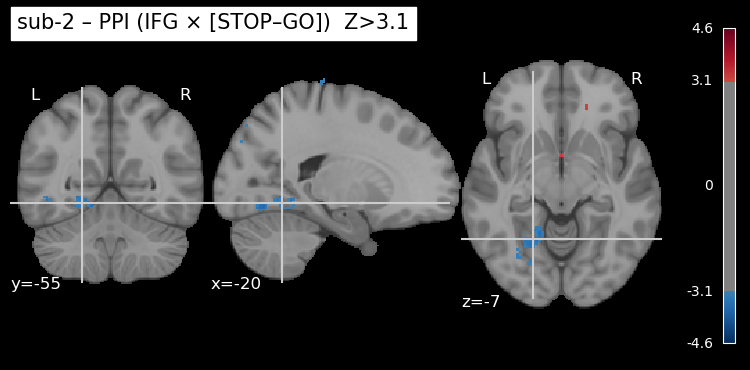

In [5]:
# ===== Task 9: PPI-lite (SST) with Right IFG seed =====
from pathlib import Path
import numpy as np
import pandas as pd
from nilearn import image, datasets, plotting
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.maskers import NiftiSpheresMasker   # if older nilearn: from nilearn.input_data import NiftiSpheresMasker
from nilearn.image import resample_to_img, math_img
import nibabel as nib
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
BASE = Path(r"H:\ML.neuroimaging\teaching\S 11\data.project")
SUBS = ["sub-1", "sub-2"]
SPHERE_MM = 6
FALLBACK_RIFG = (50, 16, 6)        # canonical R-IFG MNI
SAVE_MAPS = False                  # set True to save per-subject PPI z-maps

# ---------------- HELPERS ----------------
def find_one(folder: Path, pattern: str) -> Path:
    hits = sorted(folder.glob(pattern))
    if not hits:
        raise FileNotFoundError(f"No file matching '{pattern}' in {folder}")
    return hits[0]

def zscore(x):
    x = np.asarray(x, float)
    return (x - x.mean()) / (x.std() + 1e-8)

def pick_rifg_from_stopgo(z_map_img, ho_img):
    """
    Pick a right-hemisphere IFG peak from a Stop>Go z-map.
    Resamples HO atlas to z-map space; uses IFG triangularis/opercularis (labels 5,6).
    Falls back to canonical R-IFG if no suprathreshold voxels in IFG.
    """
    ho_in_z = resample_to_img(ho_img, z_map_img, interpolation="nearest",
                              force_resample=True, copy_header=True)
    ifg_mask = math_img("(img==5) + (img==6)", img=ho_in_z)
    z_ifg = math_img("z * (m>0)", z=z_map_img, m=ifg_mask)
    data = z_ifg.get_fdata()
    if not np.isfinite(data).any():
        return FALLBACK_RIFG
    # Keep RIGHT hemisphere only
    aff = z_ifg.affine
    nx = data.shape[0]
    xs = np.arange(nx)
    world_x = aff[0, 0]*xs + aff[0, 3]
    right = world_x > 0
    if not right.any():
        right = xs > xs.mean()
    data2 = data.copy()
    data2[~right, :, :] = -np.inf
    if not np.isfinite(data2).any():
        return FALLBACK_RIFG
    i, j, k = np.unravel_index(np.nanargmax(data2), data.shape)
    x, y, z = nib.affines.apply_affine(aff, [i, j, k])
    return (float(abs(x)), float(y), float(z))  # ensure right (x>0)

# ---------------- ATLAS (for IFG masking) ----------------
ho = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm")
ho_img = ho.maps

# ---------------- MAIN: per subject ----------------
for sub in SUBS:
    print(f"\n=== {sub}: PPI-lite during SST ===")
    sst_dir = BASE / sub / "func" / "stopsignal_task"
    bold_path = sst_dir / f"swau{sub}_task-stopsignal_bold.nii"
    events_path = sst_dir / f"{sub}_task-stopsignal_events.tsv"
    conf_path   = sst_dir / f"{sub}_sst_confounds.tsv"  # from Task 2

    # 1) Load data
    img = image.load_img(bold_path)
    tr = float(img.header.get_zooms()[-1])
    n_scans = img.shape[-1]
    frame_times = np.arange(n_scans) * tr

    events = pd.read_csv(events_path, sep="\t")
    conf   = pd.read_csv(conf_path,   sep="\t")

    # 2) Seed coordinate from Stop>Go z-map if available (else fallback)
    try:
        zmap_path = sst_dir / f"{sub}_Stop_vs_Go_zmap.nii.gz"
        zmap = image.load_img(zmap_path)
        seed_xyz = pick_rifg_from_stopgo(zmap, ho_img)
        print(f"  R-IFG seed from Stop>Go: {seed_xyz}")
    except Exception:
        seed_xyz = FALLBACK_RIFG
        print(f"  R-IFG seed fallback: {seed_xyz}")

    # 3) Build base task design (STOP, GO) + drifts + confounds
    #    Clean events quickly: keep onset/duration/trial_type and drop NaNs/out-of-scan
    ev = events[['onset','duration','trial_type']].dropna()
    scan_dur = n_scans * tr
    eps = 1e-6
    ev = ev[(ev['onset'] >= 0) & (ev['onset'] < scan_dur - eps)].copy()
    ev['duration'] = ev['duration'].clip(lower=0, upper=(scan_dur - ev['onset'] - eps))

    # Make a base design matrix
    base_dm = make_first_level_design_matrix(
        frame_times=frame_times,
        events=ev,
        hrf_model="spm",
        drift_model="cosine",
        add_regs=conf.values,
        add_reg_names=list(conf.columns),
    )
    # Identify task columns (case-insensitive contains)
    cols = list(base_dm.columns)
    stop_cols = [c for c in cols if "stop" in c.lower()]
    go_cols   = [c for c in cols if "go"   in c.lower()]

    if not stop_cols or not go_cols:
        print("  WARNING: Could not find both STOP and GO columns; using 'trial_type' as-is may be necessary.")
    # Psychological regressor = STOP - GO (sum if multiple columns, e.g., parametric)
    psycho = base_dm[stop_cols].sum(axis=1) - base_dm[go_cols].sum(axis=1)
    psycho = zscore(psycho.values)

    # 4) Physiological regressor (seed time series from the BOLD run, denoised by confounds)
    spheres = NiftiSpheresMasker([seed_xyz], radius=SPHERE_MM,
                                 standardize=True, detrend=True,
                                 low_pass=0.08, high_pass=0.009, t_r=tr)
    seed_ts = spheres.fit_transform(img, confounds=conf).ravel()
    seed_ts = zscore(seed_ts)

    # 5) PPI regressor: interaction of z-scored physio and psycho
    ppi = seed_ts * psycho

    # 6) Final design: add seed and ppi columns to base_dm
    dm = base_dm.copy()
    dm["seed_IFG"] = seed_ts
    dm["ppi_IFG_x_(STOP-GO)"] = ppi

    # 7) Fit GLM with custom design matrix
    glm = FirstLevelModel(
        t_r=tr, hrf_model=None, drift_model=None,  # we already included HRF & drifts in dm
        noise_model="ar1", standardize=False, minimize_memory=False
    )
    glm = glm.fit(run_imgs=img, design_matrices=[dm])

    # 8) PPI map: test the interaction column
    #    (nilearn lets you refer to columns by name)
    z_map = glm.compute_contrast("ppi_IFG_x_(STOP-GO)", output_type="z_score")

    # 9) Show (and optionally save) PPI z-map
    plotting.plot_stat_map(
        z_map, bg_img=datasets.load_mni152_template(),
        threshold=3.1, display_mode="ortho",
        title=f"{sub} – PPI (IFG × [STOP–GO])  Z>3.1"
    )
    plotting.show()

    if SAVE_MAPS:
        out = sst_dir / f"{sub}_PPI_IFG_STOPminusGO_zmap.nii.gz"
        z_map.to_filename(out)
        print(f"  Saved: {out.name}")


# 🧠 **Task 10 — Network metrics mini-graph (DMN & Control)**

### 🎯 Goal

Turn your **ROI↔ROI Fisher-Z** matrices (from Task 6) into a simple **brain network**, then quantify and visualize it.

### 🧩 What you’ll do

1. **Load** each subject’s ROI Fisher-Z matrix (`*_HO_FisherZ.csv`) and make a **group-average** matrix.
2. **Threshold** by the **top 15%** strongest edges (by |Z|) to define a sparse network.
3. **Compute node metrics**:

   * **Degree** (number of suprathreshold edges)
   * **Strength** (sum of |Z| weights)
   * **Weighted clustering coefficient**
4. **Compare networks**: summarize metrics for **DMN** nodes vs a simple **Frontoparietal/Control** set.
5. **Visualize**: (i) the thresholded matrix; (ii) a small **graph** with edge width ∝ |Z| and color by sign.

### 📦 What you hand in

* A **thresholded average matrix** plot,
* A **network graph** plot,
* A small **metrics table** (DMN vs Control means) + **2–3 sentences** interpreting which nodes behave like hubs.

[fetch_atlas_harvard_oxford] Dataset found in C:\Users\Saye\nilearn_data\fsl
Thresholded at |Z| ≥ 1.00 → kept 170 edges (15% of possible).

=== Network metric means (group-average graph) ===
         degree  strength(|Z|)  clustering_w
network                                     
DMN         2.0           2.23          0.07
Control     4.0           4.46          0.17
Other       8.0          10.28          0.31


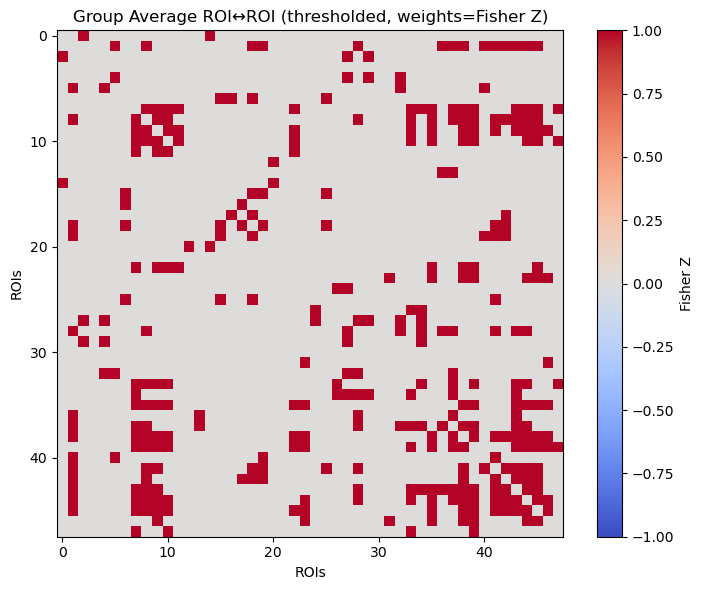

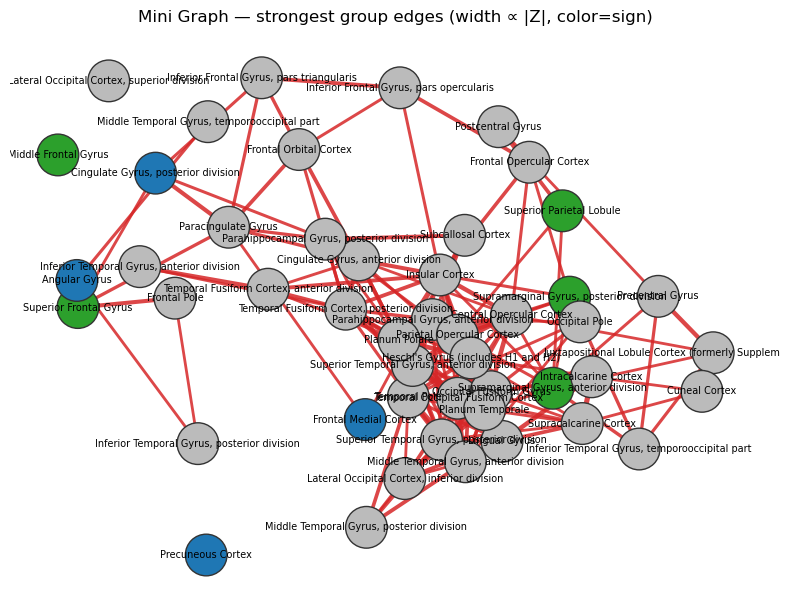


Top 10 hubs by strength(|Z|), then degree:


,node,network,degree,strength(|Z|),clustering_w
0,Heschl's Gyrus (includes H1 and H2),Other,17,23.23,0.36
1,Planum Polare,Other,16,21.81,0.35
2,Planum Temporale,Other,15,21.61,0.41
3,Temporal Occipital Fusiform Cortex,Other,16,21.57,0.38
4,"Superior Temporal Gyrus, anterior division",Other,15,20.33,0.40
5,Occipital Fusiform Gyrus,Other,15,19.92,0.38
6,Temporal Pole,Other,15,19.63,0.35
7,"Superior Temporal Gyrus, posterior division",Other,14,18.58,0.40
8,Insular Cortex,Other,14,18.46,0.27
9,Lingual Gyrus,Other,12,16.95,0.48


In [9]:
# ===== Task 10: Network metrics mini-graph (DMN & Control) =====
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx  # if missing: pip install networkx
from nilearn import datasets

# -------- CONFIG --------
BASE = Path(r"H:\ML.neuroimaging\teaching\S 11\data.project")
SUBS = ["sub-1", "sub-2"]
ATLAS_NAME = "cort-maxprob-thr25-2mm"
TOP_KEEP = 0.15   # keep top 15% strongest |Z| edges

# Define networks using Harvard–Oxford label substrings
DMN_NAMES = [
    "Cingulate Gyrus, posterior division",  # PCC
    "Precuneous Cortex",                    # Precuneus
    "Angular Gyrus",                        # Angular
    "Frontal Medial Cortex",                # mPFC
]
CTRL_NAMES = [  # simple frontoparietal/control proxy
    "Middle Frontal Gyrus",
    "Superior Frontal Gyrus",
    "Superior Parietal Lobule",
    "Supramarginal Gyrus, anterior division",
    "Supramarginal Gyrus, posterior division",
]

# -------- Helpers --------
def find_one(folder: Path, pattern: str) -> Path:
    hits = sorted(folder.glob(pattern))
    if not hits:
        raise FileNotFoundError(f"No file matching '{pattern}' in {folder}")
    return hits[0]

def pick_indices(labels, name_list):
    idxs = []
    for name in name_list:
        matches = [i for i, l in enumerate(labels) if name.lower() in l.lower()]
        if matches:
            idxs.extend(matches)
    # de-duplicate but preserve order
    seen, out = set(), []
    for i in idxs:
        if i not in seen:
            out.append(i); seen.add(i)
    return out

# -------- Load labels to ensure consistent order (no 'Background') --------
ho = datasets.fetch_atlas_harvard_oxford(ATLAS_NAME)
labels_full = list(ho.labels)
labels = labels_full[1:]  # drop 'Background'

# -------- Load each subject matrix, align to labels, and average --------
mats = []
for sub in SUBS:
    f = BASE / sub / "func" / "rest" / f"{sub}_HO_FisherZ.csv"
    Z = pd.read_csv(f, index_col=0).reindex(index=labels, columns=labels).values
    mats.append(Z)
Zavg = np.mean(mats, axis=0)

# zero diag; ensure symmetry
np.fill_diagonal(Zavg, 0)
Zavg = (Zavg + Zavg.T) / 2.0

# -------- Threshold by top |Z| % (upper triangle) --------
N = Zavg.shape[0]
# collect upper-tri absolute values excluding diagonal
iu = np.triu_indices(N, k=1)
abs_vals = np.abs(Zavg[iu])
# percentile threshold for top TOP_KEEP
thr = np.percentile(abs_vals, 100 * (1 - TOP_KEEP))
mask = np.zeros_like(Zavg, dtype=bool)
mask[iu] = np.abs(Zavg[iu]) >= thr
mask = mask | mask.T  # symmetrize
A = np.where(mask, Zavg, 0.0)  # weighted adjacency (keep sign)

print(f"Thresholded at |Z| ≥ {thr:.2f} → kept {mask.sum()//2} edges "
      f"({TOP_KEEP*100:.0f}% of possible).")

# -------- Build graphs: signed for coloring, abs-weight for metrics --------
G_signed = nx.Graph()
for i, lbl in enumerate(labels):
    G_signed.add_node(i, label=lbl)

edges = []
for i in range(N):
    for j in range(i+1, N):
        if A[i, j] != 0:
            edges.append((i, j, float(A[i, j])))
# add with sign
G_signed.add_weighted_edges_from(edges)

# Graph for metrics with absolute weights
G_abs = nx.Graph()
G_abs.add_nodes_from(G_signed.nodes(data=True))
G_abs.add_weighted_edges_from([(u, v, abs(w)) for u, v, w in edges])

# -------- Per-node metrics --------
degree = dict(G_signed.degree())  # unweighted degree (edge count)
strength = {n: sum(d['weight'] for _, _, d in G_abs.edges(n, data=True)) for n in G_abs.nodes()}
clustering_w = nx.clustering(G_abs, weight='weight')  # weighted clustering (abs weights)

metrics_df = pd.DataFrame({
    "node": [labels[n] for n in G_signed.nodes()],
    "degree": [degree[n] for n in G_signed.nodes()],
    "strength(|Z|)": [strength[n] for n in G_signed.nodes()],
    "clustering_w": [clustering_w[n] for n in G_signed.nodes()],
})

# -------- Network assignment (DMN / Control / Other) --------
dmn_idx = pick_indices(labels, DMN_NAMES)
ctrl_idx = pick_indices(labels, CTRL_NAMES)

def net_of(i):
    if i in dmn_idx: return "DMN"
    if i in ctrl_idx: return "Control"
    return "Other"

metrics_df["network"] = [net_of(i) for i in range(N)]

# ------- Show network summary (means) -------
summary = (metrics_df
           .groupby("network")[["degree","strength(|Z|)","clustering_w"]]
           .mean()
           .round(2)
           .reindex(["DMN","Control","Other"]))
print("\n=== Network metric means (group-average graph) ===")
print(summary)

# --------- Plot 1: Thresholded average matrix ---------
plt.figure(figsize=(7.5, 6))
vmax = 1.0
plt.imshow(A, vmin=-vmax, vmax=vmax, cmap="coolwarm", interpolation="nearest")
plt.title("Group Average ROI↔ROI (thresholded, weights=Fisher Z)")
plt.xlabel("ROIs"); plt.ylabel("ROIs")
cbar = plt.colorbar(label="Fisher Z")
plt.tight_layout(); plt.show()

# --------- Plot 2: Mini graph (DMN & Control highlighted) ---------
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G_abs, seed=42, k=0.7)  # stable layout

# node colors by network
colors = []
for i in G_abs.nodes():
    group = net_of(i)
    if group == "DMN":
        colors.append("#1f77b4")  # blue
    elif group == "Control":
        colors.append("#2ca02c")  # green
    else:
        colors.append("#bbbbbb")  # gray

# edge widths by |Z|; colors by sign
edge_widths = [2.0 * d["weight"] for _, _, d in G_abs.edges(data=True)]  # uses abs weight
edge_colors = ["#d62728" if G_signed[u][v]["weight"] > 0 else "#1f78b4"
               for u, v in G_abs.edges()]  # red=positive, blue=negative

nx.draw_networkx_nodes(G_abs, pos, node_color=colors, edgecolors="#333", node_size=900)
nx.draw_networkx_labels(G_abs, pos,
                        labels={i: labels[i] for i in G_abs.nodes()},
                        font_size=7)
nx.draw_networkx_edges(G_abs, pos, width=edge_widths, edge_color=edge_colors, alpha=0.85)

plt.title("Mini Graph — strongest group edges (width ∝ |Z|, color=sign)")
plt.axis("off"); plt.tight_layout(); plt.show()

# -------- Optional: show top-10 hubs --------
top_hubs = (metrics_df.sort_values(["strength(|Z|)","degree"], ascending=False)
            .head(10)
            .reset_index(drop=True))
print("\nTop 10 hubs by strength(|Z|), then degree:")
top_hubs[["node","network","degree","strength(|Z|)","clustering_w"]].round(2)
